##Download Dataset

In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from keras.datasets import fashion_mnist
from keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Add, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras import backend as K
from keras.layers import Layer
from keras import regularizers
from keras.layers import Activation, Dropout
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from keras.datasets import cifar10
from keras import models, layers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
cifar10 = tf.keras.datasets.cifar10
(X_train1, y_train1), (X_test1, y_test1) = fashion_mnist.load_data()
(X_train2, y_train2), (X_test2, y_test2) = cifar10.load_data()
print('data_shape of fashion mnist dataset:', X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
print('data_shape of CIFAR10 dataset:', X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

data_shape of fashion mnist dataset: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
data_shape of CIFAR10 dataset: (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
x_train1, x_test1 = np.expand_dims(X_train1, axis=-1) / 255.0, np.expand_dims(X_test1, axis=-1) / 255.0
x_train2, x_test2 = X_train2 / 255.0, X_test2 / 255.0

# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)
# print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

Fashion Label example: T-shirt


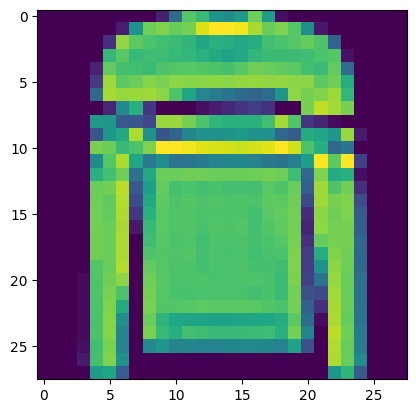

In [4]:
fashion_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
img_index = 5
y_train_label_demo = to_categorical(y_train1, 10)

label_index = y_train_label_demo[img_index][0]
plt.imshow(X_train1[img_index])

print("Fashion Label example:", fashion_labels[int(label_index)])

CIFAR Label example: automobile


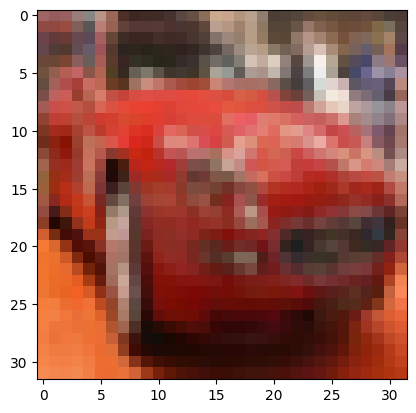

In [5]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer",
                  "dog", "frog", "horse", "ship", "truck"]
img_index = 5
label_index = y_train2[img_index][0]
plt.imshow(X_train2[img_index])

print("CIFAR Label example:", cifar10_labels[label_index])

##Why we need to run the K-Fold experiments according to the label distribution?

Simple CNN Baseline

In [ ]:
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    return model

We use CIFAR-10 to perform the experiments and oberseve the results.

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train2, x_test2 = X_train2 / 255.0, X_test2 / 255.0

# We manually create a biased label in the training set.
# Suppose we split the training set into following label distribution. The general split ratio for the whole dataset remains as 8:2
desired_samples_train = {
    0: 4500,
    1: 500,
    2: 4500,
    3: 4500,
    4: 4500,
    5: 4500,
    6: 4500,
    7: 4500,
    8: 4000,
    9: 4000
}

desired_samples_val = {
    0: 500,
    1: 4500,
    2: 500,
    3: 500,
    4: 500,
    5: 500,
    6: 500,
    7: 500,
    8: 1000,
    9: 1000
}

def custom_train_val_split(x, y, desired_samples_train, desired_samples_val, random_state=0):
    x_train, x_val, y_train, y_val = [], [], [], []
    label_count_train = defaultdict(int)
    label_count_val = defaultdict(int)

    for i in range(len(x)):
        label = int(y[i])
        if label_count_train[label] < desired_samples_train[label]:
            x_train.append(x[i])
            y_train.append(y[i])
            label_count_train[label] += 1
        elif label_count_val[label] < desired_samples_val[label]:
            x_val.append(x[i])
            y_val.append(y[i])
            label_count_val[label] += 1

    return np.array(x_train), np.array(x_val), np.array(y_train), np.array(y_val)

x_train_custom, x_val_custom, y_train_custom, y_val_custom = custom_train_val_split(x_train2, y_train2, desired_samples_train, desired_samples_val)

model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train_custom, y_train_custom, epochs=10, validation_data=(x_val_custom, y_val_custom))

test_loss, test_acc = model.evaluate(x_test2, y_test2, verbose=2)
print("Test accuracy:", test_acc)

# predictions = model.predict(x_test)


<ipython-input-7-a6065a1e5d28>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y[i])


Epoch 1/10
1250/1250 [==============================] - 18s 9ms/step - loss: 1.5560 - accuracy: 0.4253 - val_loss: 1.5447 - val_accuracy: 0.3857
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2076 - accuracy: 0.5713 - val_loss: 1.5721 - val_accuracy: 0.4464
Epoch 3/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0647 - accuracy: 0.6241 - val_loss: 1.3898 - val_accuracy: 0.5155
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9726 - accuracy: 0.6558 - val_loss: 1.6075 - val_accuracy: 0.4490
Epoch 5/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.9015 - accuracy: 0.6805 - val_loss: 1.3451 - val_accuracy: 0.5350
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8387 - accuracy: 0.7053 - val_loss: 1.1258 - val_accuracy: 0.6293
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7911 - accuracy: 0.7225 - val_loss: 1.1540 - val_accurac

In [ ]:
# With the same architecture, we split the dataset with equal label distribution
desired_samples_train = {
    0: 4000,
    1: 4000,
    2: 4000,
    3: 4000,
    4: 4000,
    5: 4000,
    6: 4000,
    7: 4000,
    8: 4000,
    9: 4000
}

desired_samples_val = {
    0: 1000,
    1: 1000,
    2: 1000,
    3: 1000,
    4: 1000,
    5: 1000,
    6: 1000,
    7: 1000,
    8: 1000,
    9: 1000
}

def custom_train_val_split(x, y, desired_samples_train, desired_samples_val, random_state=0):
    x_train, x_val, y_train, y_val = [], [], [], []
    label_count_train = defaultdict(int)
    label_count_val = defaultdict(int)

    for i in range(len(x)):
        label = int(y[i])
        if label_count_train[label] < desired_samples_train[label]:
            x_train.append(x[i])
            y_train.append(y[i])
            label_count_train[label] += 1
        elif label_count_val[label] < desired_samples_val[label]:
            x_val.append(x[i])
            y_val.append(y[i])
            label_count_val[label] += 1

    return np.array(x_train), np.array(x_val), np.array(y_train), np.array(y_val)

x_train_custom, x_val_custom, y_train_custom, y_val_custom = custom_train_val_split(x_train2, y_train2, desired_samples_train, desired_samples_val)

model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train_custom, y_train_custom, epochs=10, validation_data=(x_val_custom, y_val_custom))

test_loss, test_acc = model.evaluate(x_test2, y_test2, verbose=2)
print("Test accuracy:", test_acc)

# predictions = model.predict(x_test)


<ipython-input-8-617ad875113b>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y[i])


Epoch 1/10
1250/1250 [==============================] - 8s 5ms/step - loss: 1.5712 - accuracy: 0.4238 - val_loss: 1.3922 - val_accuracy: 0.4983
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2150 - accuracy: 0.5694 - val_loss: 1.1493 - val_accuracy: 0.5985
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0490 - accuracy: 0.6273 - val_loss: 1.0355 - val_accuracy: 0.6387
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9453 - accuracy: 0.6660 - val_loss: 1.0171 - val_accuracy: 0.6458
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8658 - accuracy: 0.6973 - val_loss: 0.9305 - val_accuracy: 0.6783
Epoch 6/10
1250/1250 [==============================] - 9s 8ms/step - loss: 0.7956 - accuracy: 0.7218 - val_loss: 0.8852 - val_accuracy: 0.6991
Epoch 7/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.7403 - accuracy: 0.7423 - val_loss: 0.8707 - val_accuracy:

There are around 3 difference on the accuracy performance on the testset with different dataset splitting strategy. So we stick with the equally label distribution.

# Simple-CNN Baseline Experiments with 20%, 50% and 100% of the training data

 To run the baselines. We run this to determine the dataset which will one will be a better choice in the coming experiments.

##Some visulization functions

In [6]:
# Plotting function
def plot_metrics(all_histories):
    for dataset, dataset_histories in all_histories.items():
        for ratio, history in dataset_histories.items():
            plt.figure(figsize=(14, 5))

            # Plot training & validation accuracy values
            plt.subplot(1, 2, 1)
            plt.plot(history['accuracy'])
            plt.plot(history['val_accuracy'])
            plt.title(f'{dataset.upper()} Dataset - Ratio {ratio} - model accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Val'], loc='upper left')

            # Plot training & validation loss values
            plt.subplot(1, 2, 2)
            plt.plot(history['loss'])
            plt.plot(history['val_loss'])
            plt.title(f'{dataset.upper()} Dataset - Ratio {ratio} - model loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Val'], loc='upper left')

            plt.show()

In [7]:
ratios = [0.2,0.5,1]
def load_data_equal_dist(dataset, ratio):
    # Load the data
    if dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train = np.expand_dims(X_train, axis=-1) / 255.0
        X_test = np.expand_dims(X_test, axis=-1) / 255.0
        input_shape = [28, 28, 1]
    elif dataset == 'cifar10':
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        X_train = X_train / 255.0
        X_test = X_test / 255.0
        input_shape = [32, 32, 3]

    # Stratified sampling to ensure equal distribution
    if ratio < 1:
        stratify_y = np.squeeze(y_train) if len(y_train.shape) > 1 else y_train
        X_train_resample, _, y_train_resample, _ = train_test_split(
            X_train, y_train, train_size=ratio, stratify=stratify_y,random_state = 0)
    else:
        X_train_resample, y_train_resample = X_train, y_train

    return X_train_resample, y_train_resample, X_test, y_test, input_shape

##Simple CNN architecture

In [ ]:
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

Without learning-rate scheduler and earlystopping

Experiment on Dataset: fashion_mnist, Training Ratio: 0.2
(28, 28, 1) 10
Epoch 1/200
300/300 [==============================] - 4s 5ms/step - loss: 0.8436 - accuracy: 0.6909 - val_loss: 0.5614 - val_accuracy: 0.7962
Epoch 2/200
 26/300 [=>............................] - ETA: 1s - loss: 0.5378 - accuracy: 0.8053

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 1s 5ms/step - loss: 0.5173 - accuracy: 0.8116 - val_loss: 0.4545 - val_accuracy: 0.8283
Epoch 3/200
300/300 [==============================] - 1s 5ms/step - loss: 0.4344 - accuracy: 0.8432 - val_loss: 0.4838 - val_accuracy: 0.8183
Epoch 4/200
300/300 [==============================] - 2s 5ms/step - loss: 0.3955 - accuracy: 0.8557 - val_loss: 0.4017 - val_accuracy: 0.8583
Epoch 5/200
300/300 [==============================] - 2s 7ms/step - loss: 0.3588 - accuracy: 0.8671 - val_loss: 0.3861 - val_accuracy: 0.8629
Epoch 6/200
300/300 [==============================] - 2s 5ms/step - loss: 0.3146 - accuracy: 0.8838 - val_loss: 0.3793 - val_accuracy: 0.8650
Epoch 7/200
300/300 [==============================] - 1s 5ms/step - loss: 0.2904 - accuracy: 0.8961 - val_loss: 0.3517 - val_accuracy: 0.8742
Epoch 8/200
300/300 [==============================] - 1s 5ms/step - loss: 0.2644 - accuracy: 0.9058 - val_loss: 0.3448 - val_accuracy: 0.8813
Epoch 9/200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 4s 5ms/step - loss: 0.3965 - accuracy: 0.8537 - val_loss: 0.4194 - val_accuracy: 0.8427
Epoch 3/200
750/750 [==============================] - 4s 5ms/step - loss: 0.3390 - accuracy: 0.8749 - val_loss: 0.3368 - val_accuracy: 0.8790
Epoch 4/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2995 - accuracy: 0.8900 - val_loss: 0.3085 - val_accuracy: 0.8950
Epoch 5/200
750/750 [==============================] - 4s 5ms/step - loss: 0.2706 - accuracy: 0.9000 - val_loss: 0.3055 - val_accuracy: 0.8878
Epoch 6/200
750/750 [==============================] - 4s 5ms/step - loss: 0.2463 - accuracy: 0.9084 - val_loss: 0.3141 - val_accuracy: 0.8900
Epoch 7/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2251 - accuracy: 0.9165 - val_loss: 0.3023 - val_accuracy: 0.8945
Epoch 8/200
750/750 [==============================] - 4s 5ms/step - loss: 0.2070 - accuracy: 0.9233 - val_loss: 0.2872 - val_accuracy: 0.9005
Epoch 9/200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 2s 6ms/step - loss: 1.6272 - accuracy: 0.3995 - val_loss: 1.5191 - val_accuracy: 0.4145
Epoch 3/200
250/250 [==============================] - 1s 6ms/step - loss: 1.4763 - accuracy: 0.4611 - val_loss: 1.4007 - val_accuracy: 0.4860
Epoch 4/200
250/250 [==============================] - 1s 6ms/step - loss: 1.3755 - accuracy: 0.4961 - val_loss: 1.3353 - val_accuracy: 0.5030
Epoch 5/200
250/250 [==============================] - 1s 5ms/step - loss: 1.2720 - accuracy: 0.5375 - val_loss: 1.2931 - val_accuracy: 0.5195
Epoch 6/200
250/250 [==============================] - 2s 8ms/step - loss: 1.1906 - accuracy: 0.5658 - val_loss: 1.3012 - val_accuracy: 0.5205
Epoch 7/200
250/250 [==============================] - 2s 7ms/step - loss: 1.1265 - accuracy: 0.5940 - val_loss: 1.2233 - val_accuracy: 0.5560
Epoch 8/200
250/250 [==============================] - 1s 5ms/step - loss: 1.0615 - accuracy: 0.6227 - val_loss: 1.1754 - val_accuracy: 0.5735
Epoch 9/200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 3s 5ms/step - loss: 1.3673 - accuracy: 0.5044 - val_loss: 1.2898 - val_accuracy: 0.5394
Epoch 3/200
625/625 [==============================] - 4s 6ms/step - loss: 1.2282 - accuracy: 0.5621 - val_loss: 1.1785 - val_accuracy: 0.5786
Epoch 4/200
625/625 [==============================] - 4s 7ms/step - loss: 1.1229 - accuracy: 0.6018 - val_loss: 1.1163 - val_accuracy: 0.6050
Epoch 5/200
625/625 [==============================] - 3s 5ms/step - loss: 1.0184 - accuracy: 0.6391 - val_loss: 1.1044 - val_accuracy: 0.6024
Epoch 6/200
625/625 [==============================] - 3s 6ms/step - loss: 0.9398 - accuracy: 0.6705 - val_loss: 1.0283 - val_accuracy: 0.6412
Epoch 7/200
625/625 [==============================] - 4s 6ms/step - loss: 0.8665 - accuracy: 0.6966 - val_loss: 1.0018 - val_accuracy: 0.6544
Epoch 8/200
625/625 [==============================] - 5s 8ms/step - loss: 0.7948 - accuracy: 0.7193 - val_loss: 1.0424 - val_accuracy: 0.6292
Epoch 9/200

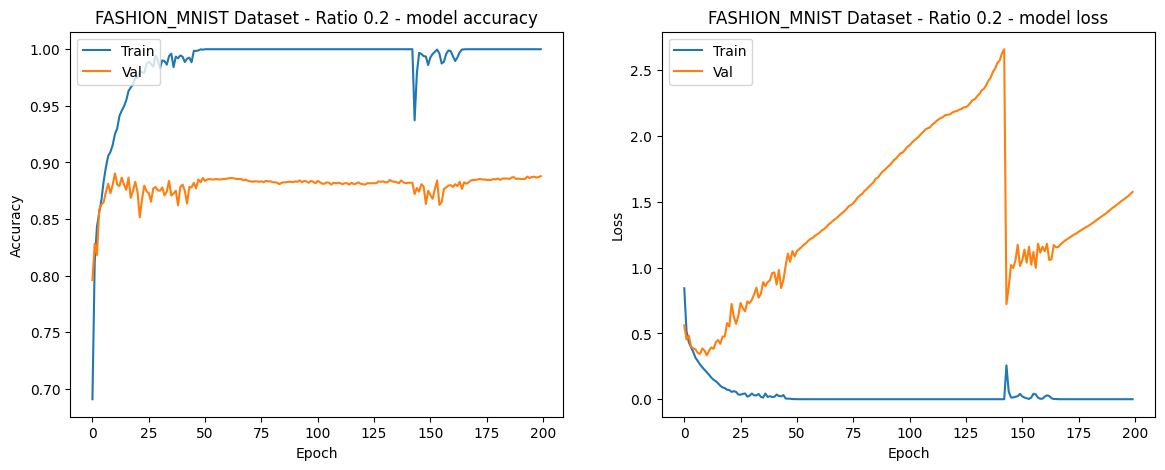

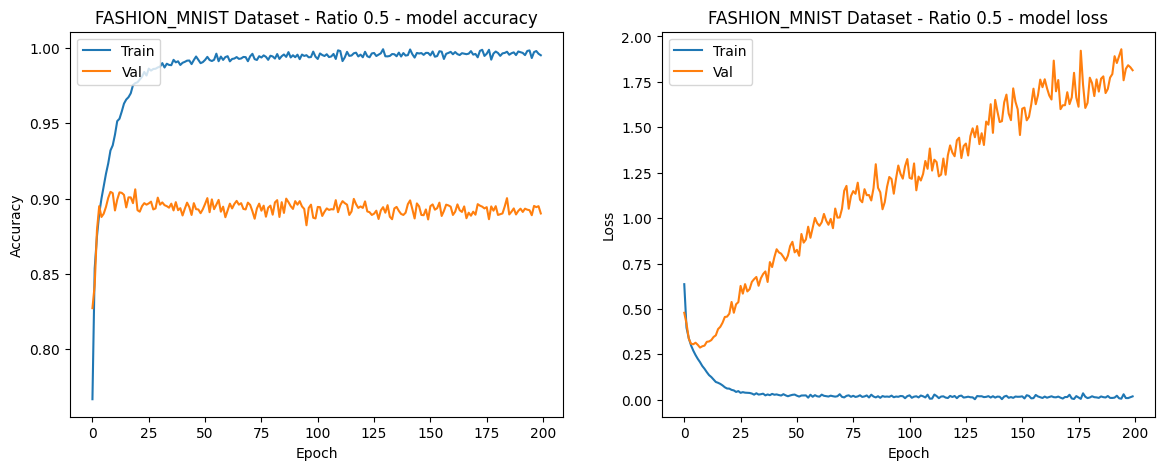

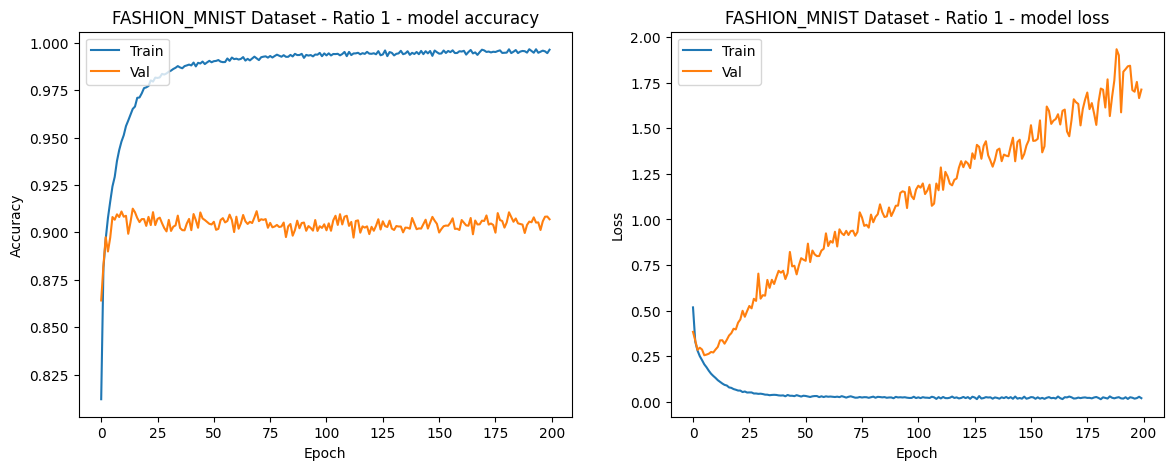

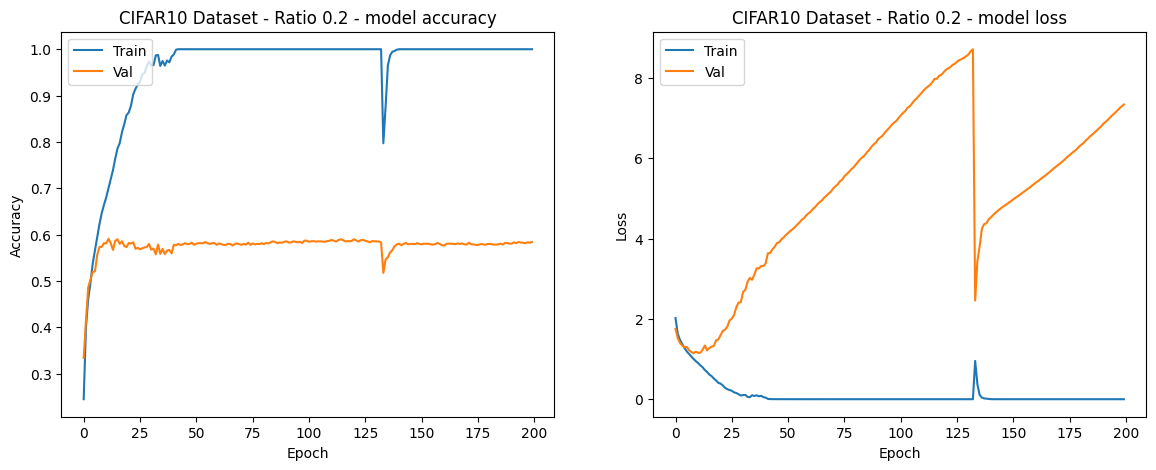

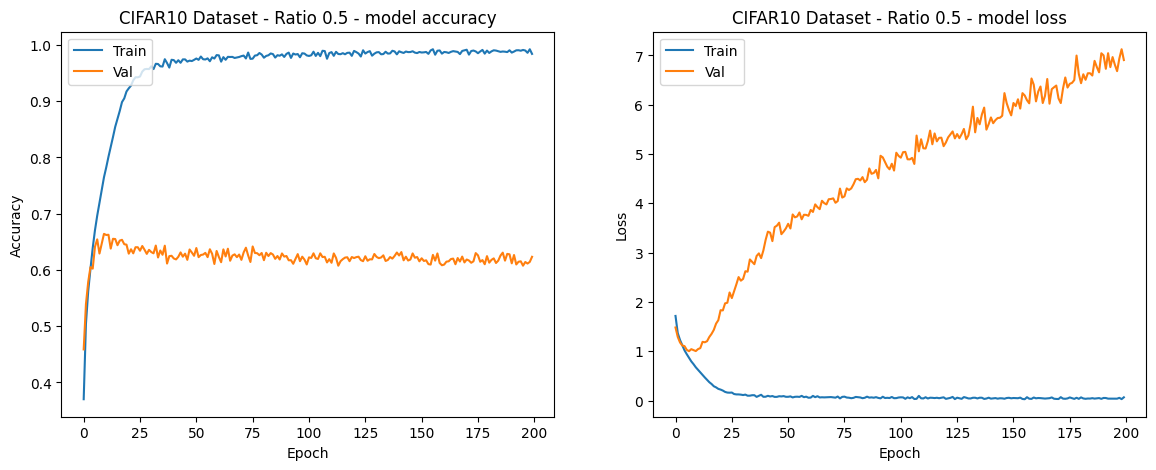

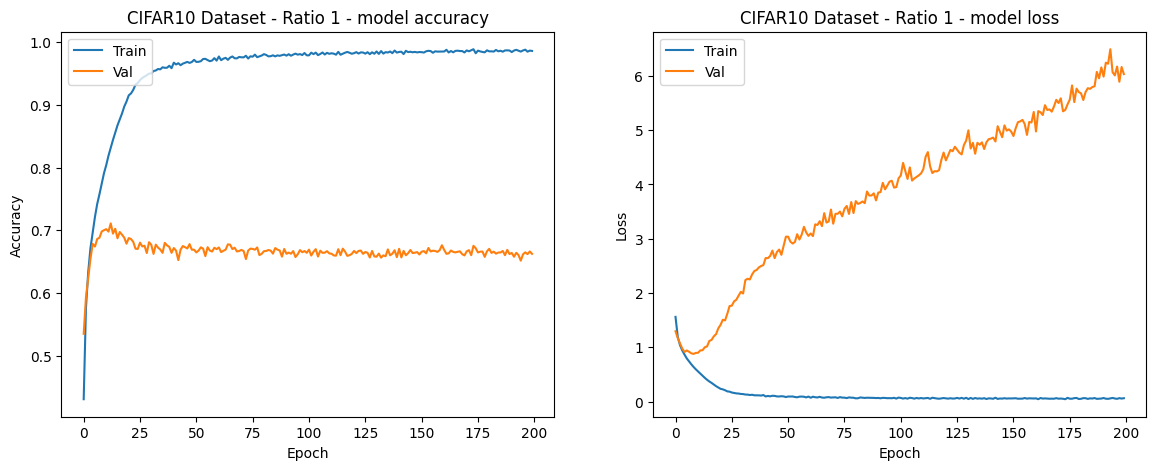

In [ ]:
all_histories = {}

# Experiment loop
for dataset in ['fashion_mnist', 'cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Determine the number of classes
        num_classes = len(np.unique(y_train))
        print(X_train.shape[1:], num_classes)
        model = create_model(input_shape, num_classes)
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # Adjusted loss function for easier handling of labels
                      metrics=['accuracy'])

        # Setting up EarlyStopping
        # early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        # Setting up ModelCheckpoint
        model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

        # Setting up ReduceLROnPlateau
        # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                            callbacks=[model_checkpoint])
        dataset_histories[ratio] = history.history

        # Load the best model
        model = models.load_model('best_model.h5')

        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Accuracy: {test_acc}')
        print()
    all_histories[dataset] = dataset_histories

# Call the plotting function after all experiments are done
plot_metrics(all_histories)


With learning-rate scheduler and earlystopping

Experiment on Dataset: fashion_mnist, Training Ratio: 0.2
4422102/4422102 [==============================] - 1s 0us/step
(28, 28, 1) 10
Epoch 1/200
300/300 [==============================] - 6s 6ms/step - loss: 0.8246 - accuracy: 0.6925 - val_loss: 0.5682 - val_accuracy: 0.7912 - lr: 0.0010
Epoch 2/200
 39/300 [==>...........................] - ETA: 1s - loss: 0.5775 - accuracy: 0.7853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 2s 6ms/step - loss: 0.5327 - accuracy: 0.8011 - val_loss: 0.5020 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 3/200
300/300 [==============================] - 2s 5ms/step - loss: 0.4517 - accuracy: 0.8332 - val_loss: 0.4218 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 4/200
300/300 [==============================] - 1s 4ms/step - loss: 0.3930 - accuracy: 0.8577 - val_loss: 0.3907 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 5/200
300/300 [==============================] - 1s 4ms/step - loss: 0.3475 - accuracy: 0.8721 - val_loss: 0.4113 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 6/200
300/300 [==============================] - 1s 4ms/step - loss: 0.3186 - accuracy: 0.8850 - val_loss: 0.3713 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 7/200
300/300 [==============================] - 2s 6ms/step - loss: 0.2968 - accuracy: 0.8922 - val_loss: 0.3779 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 8/200
300/300 [==============================] - 2s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 3s 4ms/step - loss: 0.4345 - accuracy: 0.8387 - val_loss: 0.3717 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 3/200
750/750 [==============================] - 4s 5ms/step - loss: 0.3576 - accuracy: 0.8698 - val_loss: 0.3269 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 4/200
750/750 [==============================] - 4s 5ms/step - loss: 0.3215 - accuracy: 0.8838 - val_loss: 0.3148 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 5/200
750/750 [==============================] - 3s 5ms/step - loss: 0.2908 - accuracy: 0.8935 - val_loss: 0.2874 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 6/200
750/750 [==============================] - 3s 4ms/step - loss: 0.2648 - accuracy: 0.9035 - val_loss: 0.2899 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 7/200
750/750 [==============================] - 4s 5ms/step - loss: 0.2449 - accuracy: 0.9098 - val_loss: 0.3025 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 8/200
750/750 [==============================] - 3s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 1s 6ms/step - loss: 1.6031 - accuracy: 0.4146 - val_loss: 1.5825 - val_accuracy: 0.4230 - lr: 0.0010
Epoch 3/200
250/250 [==============================] - 1s 5ms/step - loss: 1.4589 - accuracy: 0.4652 - val_loss: 1.4744 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 4/200
250/250 [==============================] - 1s 5ms/step - loss: 1.3352 - accuracy: 0.5197 - val_loss: 1.4558 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 5/200
250/250 [==============================] - 1s 5ms/step - loss: 1.2684 - accuracy: 0.5497 - val_loss: 1.4014 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 6/200
250/250 [==============================] - 1s 5ms/step - loss: 1.1770 - accuracy: 0.5822 - val_loss: 1.3145 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 7/200
250/250 [==============================] - 1s 5ms/step - loss: 1.1032 - accuracy: 0.6037 - val_loss: 1.3942 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 8/200
250/250 [==============================] - 1s 4ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 4s 6ms/step - loss: 1.3648 - accuracy: 0.5041 - val_loss: 1.2920 - val_accuracy: 0.5454 - lr: 0.0010
Epoch 3/200
625/625 [==============================] - 3s 4ms/step - loss: 1.2200 - accuracy: 0.5630 - val_loss: 1.1836 - val_accuracy: 0.5848 - lr: 0.0010
Epoch 4/200
625/625 [==============================] - 3s 5ms/step - loss: 1.1045 - accuracy: 0.6104 - val_loss: 1.1153 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 5/200
625/625 [==============================] - 3s 5ms/step - loss: 1.0238 - accuracy: 0.6374 - val_loss: 1.1115 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 6/200
625/625 [==============================] - 4s 6ms/step - loss: 0.9465 - accuracy: 0.6694 - val_loss: 1.0218 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 7/200
625/625 [==============================] - 3s 5ms/step - loss: 0.8802 - accuracy: 0.6899 - val_loss: 1.0165 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 8/200
625/625 [==============================] - 3s 4ms/step - loss: 0

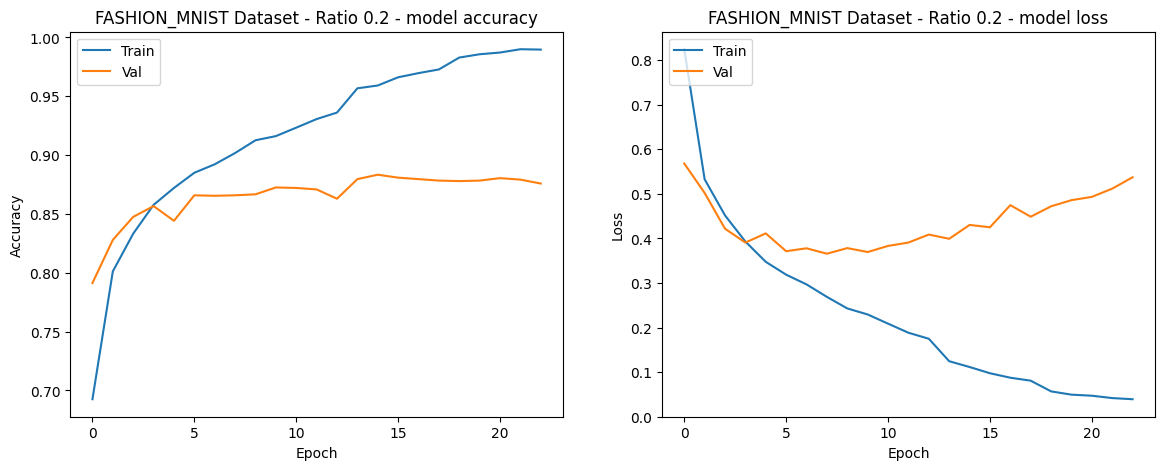

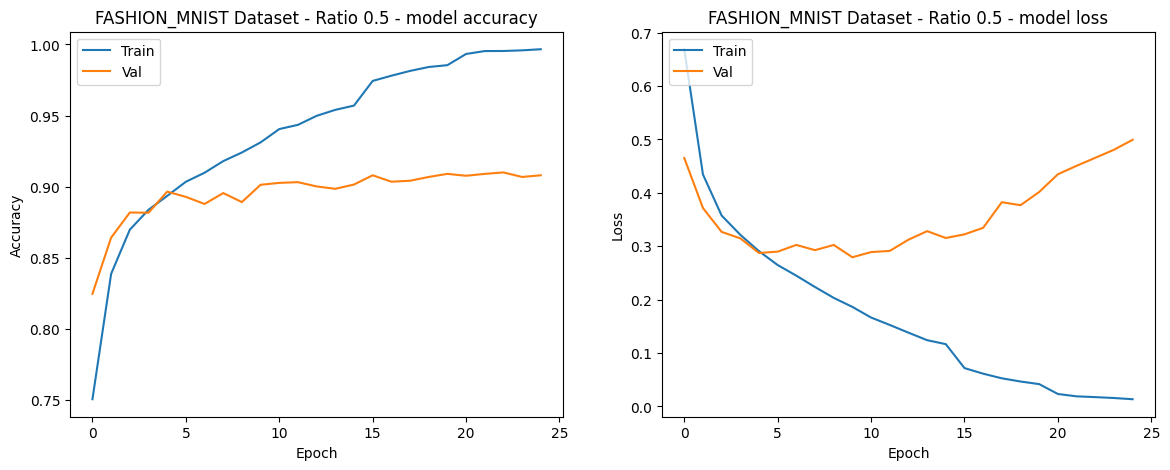

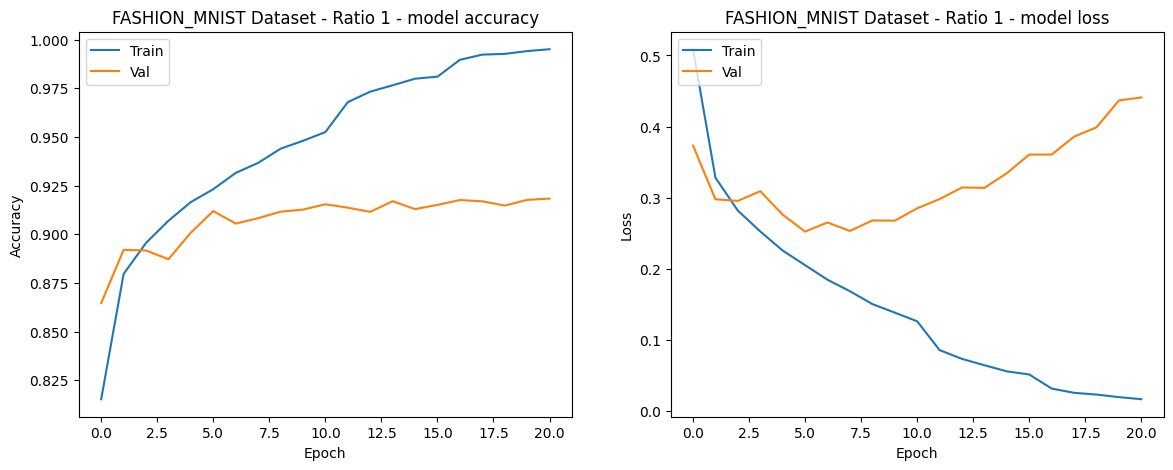

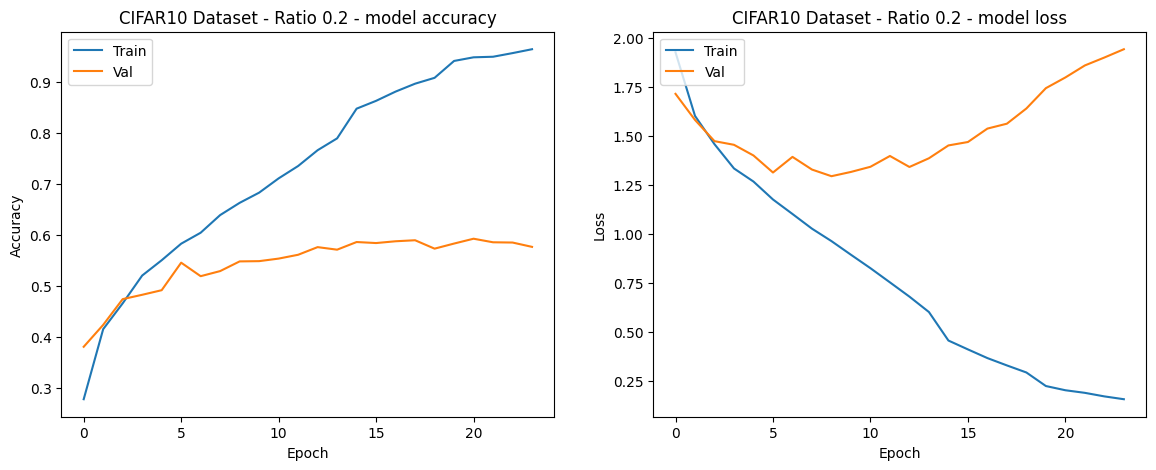

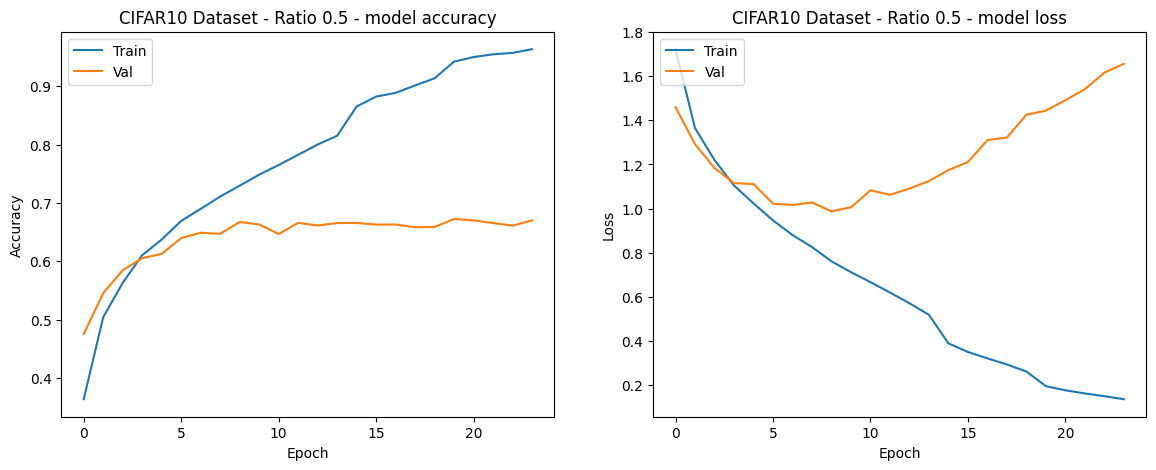

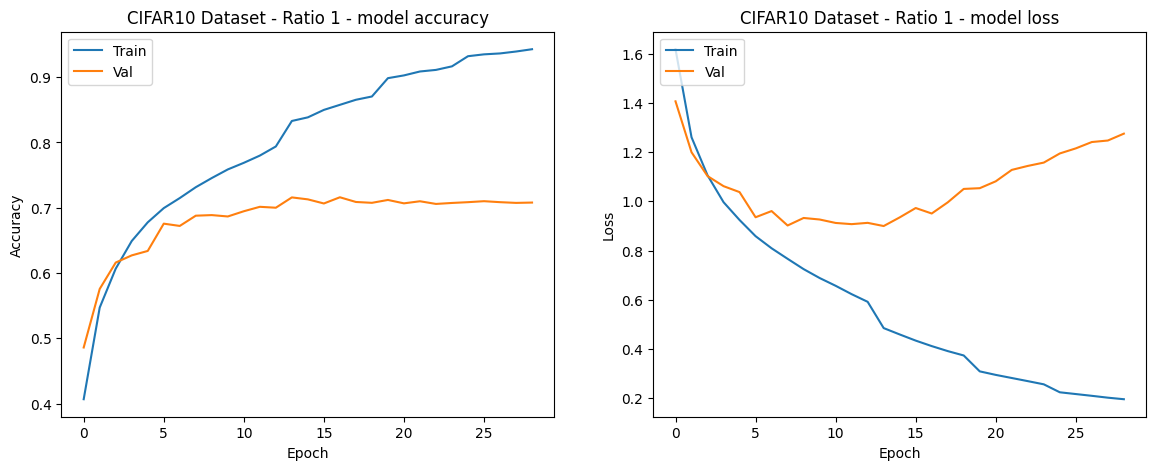

In [ ]:
all_histories = {}

# Experiment loop
for dataset in ['fashion_mnist', 'cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Determine the number of classes
        num_classes = len(np.unique(y_train))
        print(X_train.shape[1:], num_classes)
        model = create_model(input_shape, num_classes)
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # Adjusted loss function for easier handling of labels
                      metrics=['accuracy'])

        # Setting up EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        # Setting up ModelCheckpoint
        model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

        # Setting up ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        dataset_histories[ratio] = history.history

        # Load the best model
        model = models.load_model('best_model.h5')

        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Accuracy: {test_acc}')
        print()
    all_histories[dataset] = dataset_histories

# Call the plotting function after all experiments are done
plot_metrics(all_histories)


Simple-CNN with dropout and L2-regularizer

In [ ]:
from keras import regularizers

def create_model(input_shape, num_classes, dropout_rate=0.5, l2_lambda=0.0005):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

Experiment on Dataset: cifar10, Training Ratio: 0.2
(32, 32, 3) 10
Epoch 1/200
250/250 [==============================] - 8s 9ms/step - loss: 2.1767 - accuracy: 0.2037 - val_loss: 1.8873 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 2/200
 28/250 [==>...........................] - ETA: 0s - loss: 1.9830 - accuracy: 0.2600

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 1s 5ms/step - loss: 1.8861 - accuracy: 0.3100 - val_loss: 1.7428 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 3/200
250/250 [==============================] - 1s 5ms/step - loss: 1.7375 - accuracy: 0.3772 - val_loss: 1.7139 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 4/200
250/250 [==============================] - 1s 5ms/step - loss: 1.6550 - accuracy: 0.4126 - val_loss: 1.5453 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 5/200
250/250 [==============================] - 1s 5ms/step - loss: 1.5994 - accuracy: 0.4320 - val_loss: 1.5055 - val_accuracy: 0.4725 - lr: 0.0010
Epoch 6/200
250/250 [==============================] - 1s 5ms/step - loss: 1.5521 - accuracy: 0.4635 - val_loss: 1.4312 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 7/200
250/250 [==============================] - 1s 5ms/step - loss: 1.5145 - accuracy: 0.4770 - val_loss: 1.4212 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 8/200
250/250 [==============================] - 1s 5ms/step - loss: 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 3s 4ms/step - loss: 1.7178 - accuracy: 0.3808 - val_loss: 1.5178 - val_accuracy: 0.4684 - lr: 0.0010
Epoch 3/200
625/625 [==============================] - 3s 5ms/step - loss: 1.6223 - accuracy: 0.4281 - val_loss: 1.4382 - val_accuracy: 0.4926 - lr: 0.0010
Epoch 4/200
625/625 [==============================] - 3s 5ms/step - loss: 1.5255 - accuracy: 0.4734 - val_loss: 1.3838 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 5/200
625/625 [==============================] - 3s 5ms/step - loss: 1.4627 - accuracy: 0.5019 - val_loss: 1.3552 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 6/200
625/625 [==============================] - 3s 4ms/step - loss: 1.4185 - accuracy: 0.5234 - val_loss: 1.3594 - val_accuracy: 0.5492 - lr: 0.0010
Epoch 7/200
625/625 [==============================] - 3s 5ms/step - loss: 1.3720 - accuracy: 0.5474 - val_loss: 1.2866 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 8/200
625/625 [==============================] - 4s 6ms/step - loss: 1

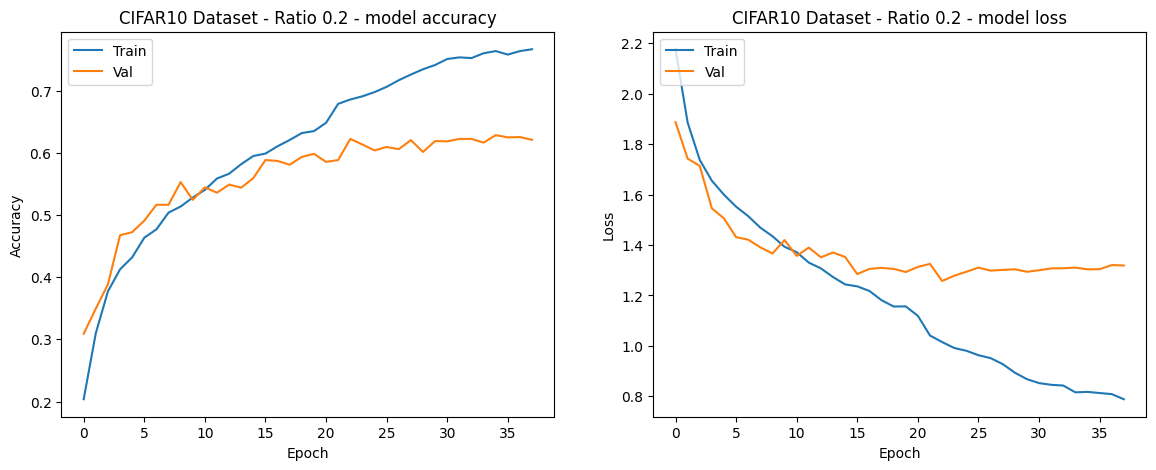

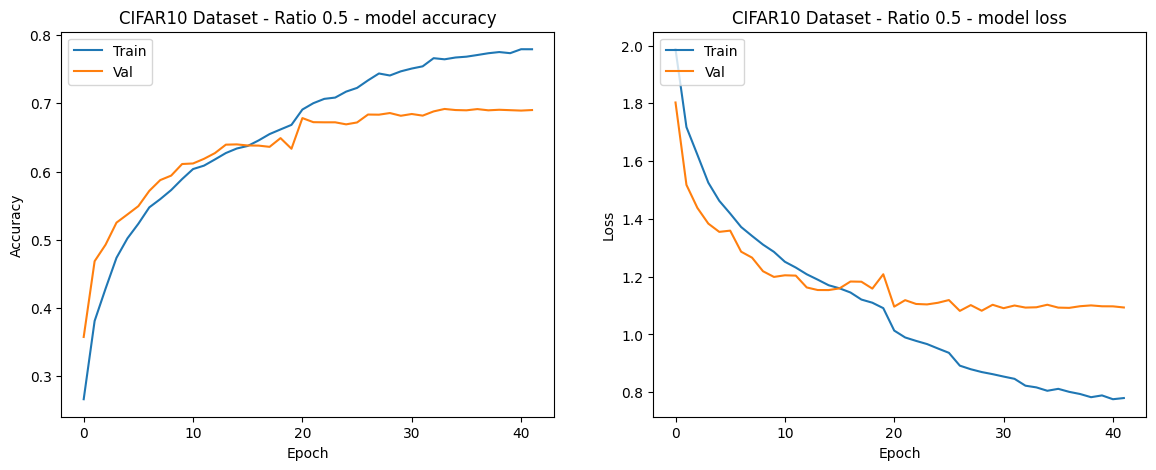

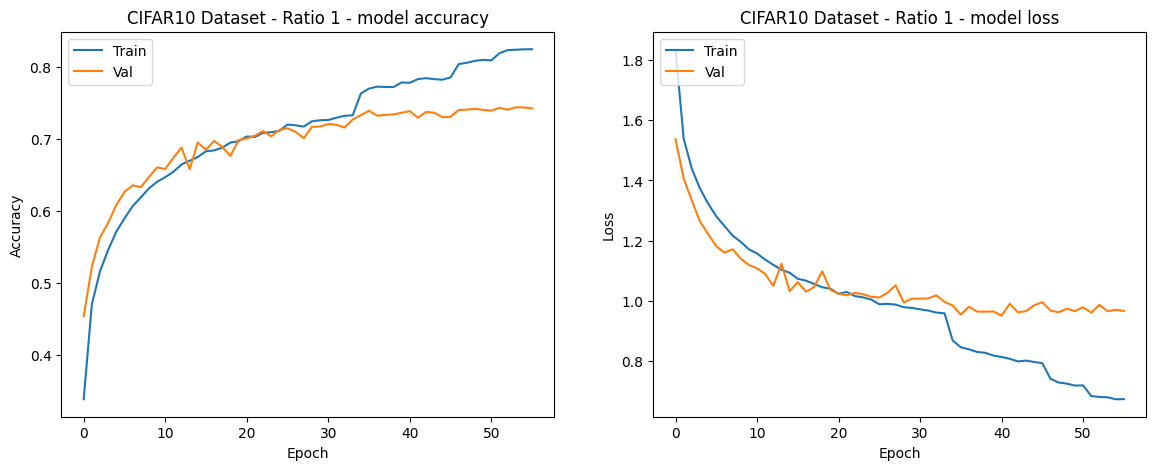

In [ ]:
all_histories = {}
ratios = [0.2,0.5,1]
# Experiment loop
for dataset in ['cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Determine the number of classes
        num_classes = len(np.unique(y_train))
        print(X_train.shape[1:], num_classes)
        model = create_model(input_shape, num_classes)
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',  # Adjusted loss function for easier handling of labels
                      metrics=['accuracy'])

        # Setting up EarlyStopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

        # Setting up ModelCheckpoint
        model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

        # Setting up ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                            callbacks=[early_stopping, model_checkpoint, reduce_lr])
        dataset_histories[ratio] = history.history

        # Load the best model
        model = models.load_model('best_model.h5')

        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Accuracy: {test_acc}')
        print()
    all_histories[dataset] = dataset_histories

# Call the plotting function after all experiments are done
plot_metrics(all_histories)


We found that there is a minor performance gap on Fashion-Mnist dataset of 20%, 50% and 100% dataset, which is not easy to observe and conclude. CIFAR-10 dataset is better for the observation, as with the different ration of training data, there are a great gap between the different models.

5-Fold validation on the Simple-CNN baseline

In [ ]:

all_histories = {}

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Load the entire CIFAR-10 dataset
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', 1)

# Determine the number of classes
num_classes = len(np.unique(y_train))

# Initialize k-fold cross-validation
# kf = KFold(n_splits=num_folds, shuffle=True)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True,random_state = 0)
# Experiment loop
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train,y_train)):
    print(f'Fold: {fold_idx + 1}/{num_folds}')

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create and compile the model
    model = create_model(input_shape, num_classes, dropout_rate=0.5, l2_lambda=0.0005)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Setting up EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    # Setting up ModelCheckpoint
    model_checkpoint = ModelCheckpoint(f'best_model_fold{fold_idx}.h5', save_best_only=True)

    # Setting up ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
    history = model.fit(X_train_fold, y_train_fold, epochs=200, validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Load the best model for this fold
    model = models.load_model(f'best_model_fold{fold_idx}.h5')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'Fold {fold_idx + 1} Test Accuracy: {test_acc}')
    # all_histories[f'Fold_{fold_idx + 1}'] = history.history


Fold: 1/5
Epoch 1/200
1000/1000 [==============================] - 13s 10ms/step - loss: 1.8888 - accuracy: 0.3190 - val_loss: 1.6277 - val_accuracy: 0.4238 - lr: 0.0010
Epoch 2/200
   8/1000 [..............................] - ETA: 8s - loss: 1.5581 - accuracy: 0.4453 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 8s 8ms/step - loss: 1.5815 - accuracy: 0.4512 - val_loss: 1.3943 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 3/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.4783 - accuracy: 0.5018 - val_loss: 1.4019 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 4/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3918 - accuracy: 0.5362 - val_loss: 1.2951 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 5/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3322 - accuracy: 0.5649 - val_loss: 1.2226 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 6/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2854 - accuracy: 0.5879 - val_loss: 1.2258 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 7/200
1000/1000 [==============================] - 5s 5ms/step - loss: 1.2554 - accuracy: 0.6044 - val_loss: 1.1341 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 8/200
1000/1000 [==============================] - 5s 5ms/

In [ ]:

all_histories = {}

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Load the entire CIFAR-10 dataset
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', 1)

# Determine the number of classes
num_classes = len(np.unique(y_train))

# Initialize k-fold cross-validation
# kf = KFold(n_splits=num_folds, shuffle=True)
kf = StratifiedKFold(n_splits=num_folds, shuffle=True,random_state = 0)
# Experiment loop
for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train,y_train)):
    print(f'Fold: {fold_idx + 1}/{num_folds}')

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create and compile the model
    model = create_model(input_shape, num_classes, dropout_rate=0.5, l2_lambda=0.0005)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Setting up EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    # Setting up ModelCheckpoint
    model_checkpoint = ModelCheckpoint(f'best_model_fold{fold_idx}.h5', save_best_only=True)

    # Setting up ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
    history = model.fit(X_train_fold, y_train_fold, epochs=200, validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Load the best model for this fold
    model = models.load_model(f'best_model_fold{fold_idx}.h5')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'Fold {fold_idx + 1} Test Accuracy: {test_acc}')
    # all_histories[f'Fold_{fold_idx + 1}'] = history.history


Fold: 1/5
Epoch 1/200
1000/1000 [==============================] - 7s 6ms/step - loss: 1.5780 - accuracy: 0.4246 - val_loss: 1.3228 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 2/200
  27/1000 [..............................] - ETA: 3s - loss: 1.3409 - accuracy: 0.5243

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 5s 5ms/step - loss: 1.2164 - accuracy: 0.5679 - val_loss: 1.1622 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 3/200
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0595 - accuracy: 0.6259 - val_loss: 1.0894 - val_accuracy: 0.6097 - lr: 0.0010
Epoch 4/200
1000/1000 [==============================] - 6s 6ms/step - loss: 0.9386 - accuracy: 0.6714 - val_loss: 0.9917 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 5/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8543 - accuracy: 0.7000 - val_loss: 0.9403 - val_accuracy: 0.6799 - lr: 0.0010
Epoch 6/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7794 - accuracy: 0.7266 - val_loss: 0.9172 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 7/200
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7265 - accuracy: 0.7451 - val_loss: 1.0279 - val_accuracy: 0.6534 - lr: 0.0010
Epoch 8/200
1000/1000 [==============================] - 5s 5ms/

Visualize the test set output with full trained model

Epoch 1/200
1250/1250 [==============================] - 9s 5ms/step - loss: 1.5608 - accuracy: 0.4272 - val_loss: 1.3282 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 2/200
  40/1250 [..............................] - ETA: 4s - loss: 1.2264 - accuracy: 0.5594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 8s 6ms/step - loss: 1.2020 - accuracy: 0.5729 - val_loss: 1.1196 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 3/200
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0440 - accuracy: 0.6304 - val_loss: 1.0804 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9438 - accuracy: 0.6658 - val_loss: 0.9502 - val_accuracy: 0.6696 - lr: 0.0010
Epoch 5/200
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8534 - accuracy: 0.7018 - val_loss: 0.9115 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/200
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7933 - accuracy: 0.7236 - val_loss: 0.9041 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 7/200
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7370 - accuracy: 0.7406 - val_loss: 0.8870 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 8/200
1250/1250 [==============================] - 10s 8m

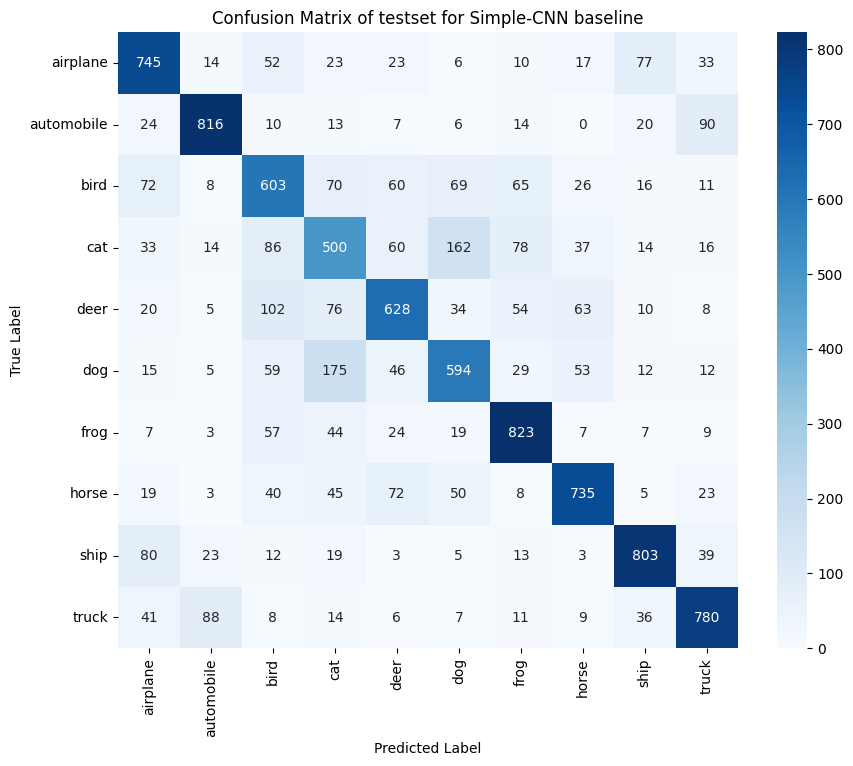

In [ ]:
# Load the CIFAR-10 dataset
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', 1)

model = create_model(input_shape, 10)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    # Setting up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

    # Setting up ModelCheckpoint
model_checkpoint = ModelCheckpoint(f'best_model.h5', save_best_only=True)

    # Setting up ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])

    # Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

# Make predictions on the test set
y_hat = model.predict(X_test)

# # Display some random images along with their predicted and true labels
# figure = plt.figure(figsize=(20, 8))
# for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
#     ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(X_test[index]))
#     predict_index = np.argmax(y_hat[index])
#     true_index = np.argmax(y_test[index])
#     ax.set_title("{} ({})".format(cifar10_labels[predict_index], cifar10_labels[true_index]),
#                  color=("green" if predict_index == true_index else "red"))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, np.argmax(y_hat, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels, yticklabels=cifar10_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of testset for Simple-CNN baseline')
plt.show()

#Training with VGG

K-fold cross validation only in CIFAR-10 dataset

##Fashion-Mnist VGG-19

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class FASHIONVGG:
    def __init__(self, input_shape, train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = input_shape

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        # else:
        #     self.model.load_weights('FASHIONVGG.h5')

    def build_model(self):
        weight_decay = self.weight_decay

        model = Sequential()
        num_max_pool_layers = 3 if self.x_shape[0] == 28 else 5  # Less pooling for smaller input

        # Block 1
        model.add(Conv2D(64, (3, 3), padding='same', input_shape=self.x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 2
        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 3
        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 4
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 5
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1
        model.add(Dropout(0.5))

        # Flatten and fully connected layers
        model.add(Flatten())
        model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        return model

    def train(self, model, X_train, y_train):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Learning rate scheduler
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                            callbacks=[early_stopping, checkpoint, reduce_lr])

        # return model, history
        return model, history

Experiment on Dataset: fashion_mnist, Training Ratio: 0.2
Epoch 1/200
299/300 [============================>.] - ETA: 0s - loss: 4.1849 - accuracy: 0.5130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 23s 47ms/step - loss: 4.1822 - accuracy: 0.5140 - val_loss: 7.2500 - val_accuracy: 0.1029 - lr: 0.0010
Epoch 2/200
300/300 [==============================] - 13s 42ms/step - loss: 3.3466 - accuracy: 0.7221 - val_loss: 3.6020 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 3/200
300/300 [==============================] - 12s 40ms/step - loss: 2.9968 - accuracy: 0.7597 - val_loss: 2.7803 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 4/200
300/300 [==============================] - 13s 43ms/step - loss: 2.6536 - accuracy: 0.7882 - val_loss: 2.4715 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 5/200
300/300 [==============================] - 13s 43ms/step - loss: 2.2773 - accuracy: 0.8165 - val_loss: 2.0896 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 6/200
300/300 [==============================] - 13s 43ms/step - loss: 1.9668 - accuracy: 0.8311 - val_loss: 1.8350 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 7/200
300/300 [==============================] - 14s 48ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 31s 41ms/step - loss: 0.6121 - accuracy: 0.9284 - val_loss: 0.6371 - val_accuracy: 0.9145 - lr: 2.5000e-04
Epoch 25/200
750/750 [==============================] - 30s 40ms/step - loss: 0.6055 - accuracy: 0.9308 - val_loss: 0.6588 - val_accuracy: 0.9168 - lr: 2.5000e-04
Epoch 26/200
750/750 [==============================] - 30s 39ms/step - loss: 0.6017 - accuracy: 0.9293 - val_loss: 0.7046 - val_accuracy: 0.9093 - lr: 2.5000e-04
Epoch 27/200
750/750 [==============================] - 30s 40ms/step - loss: 0.5795 - accuracy: 0.9337 - val_loss: 0.6639 - val_accuracy: 0.9165 - lr: 2.5000e-04
Epoch 28/200
750/750 [==============================] - 32s 43ms/step - loss: 0.5772 - accuracy: 0.9348 - val_loss: 0.6165 - val_accuracy: 0.9213 - lr: 2.5000e-04
Epoch 29/200
750/750 [==============================] - 30s 40ms/step - loss: 0.5695 - accuracy: 0.9358 - val_loss: 0.6230 - val_accuracy: 0.9180 - lr: 2.5000e-04
Epoch 30/200
750/750 [=============

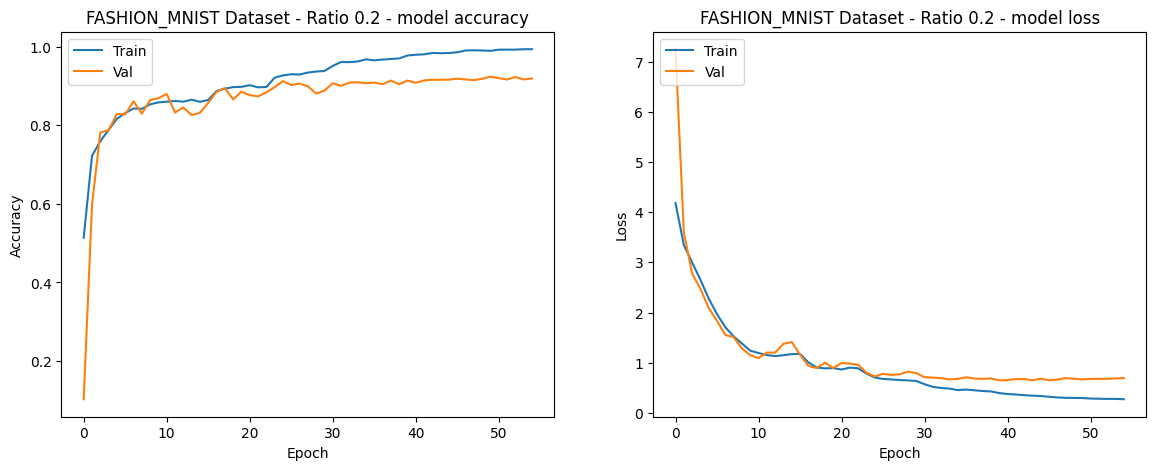

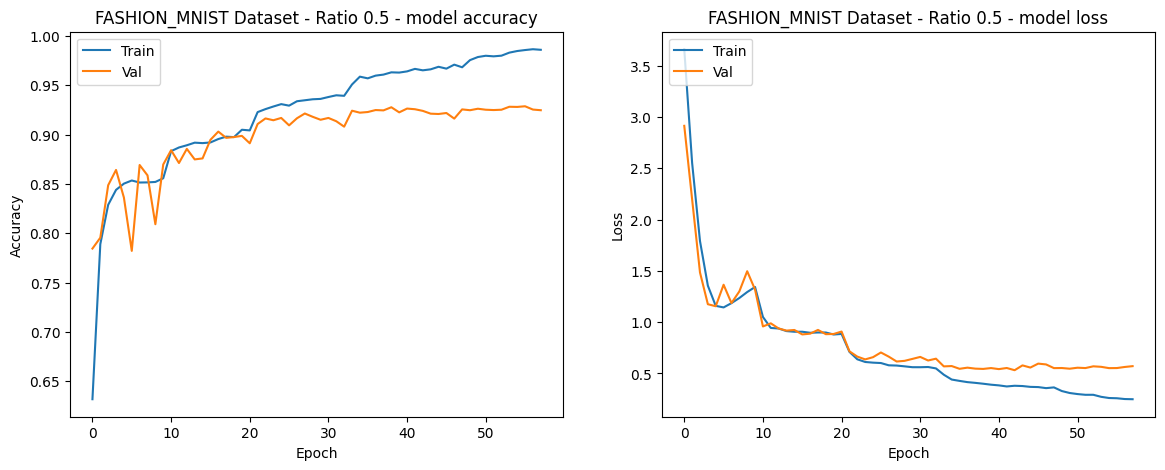

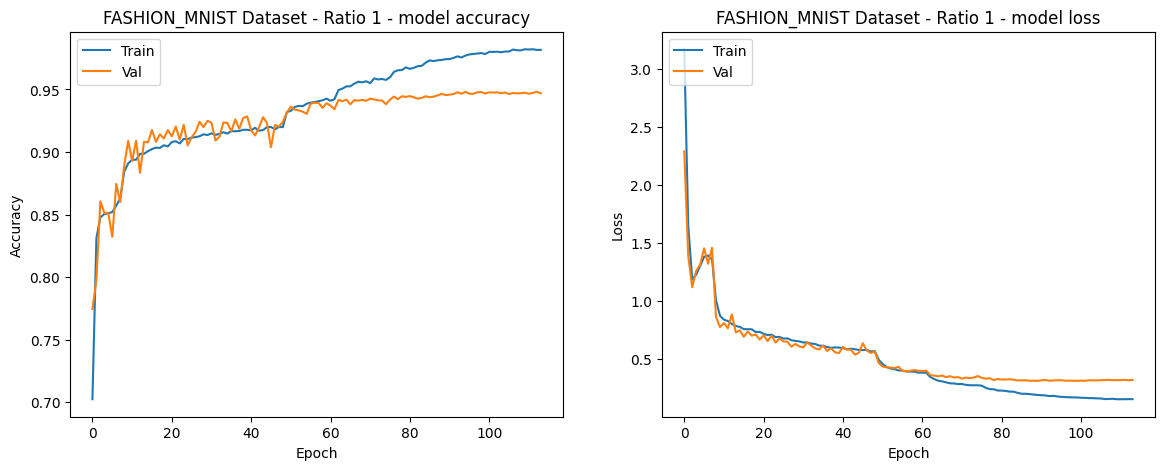

In [ ]:
all_histories = {}
# Main Loop - Iterate through datasets and ratios
for dataset in ['fashion_mnist']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')

        # Load data and get the appropriate input shape
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Initialize FASHIONVGG without training and specify the input shape
        vgg_model = FASHIONVGG(input_shape=input_shape, train=False)


        # Train the model with the currently loaded data

        vgg_model.model, history = vgg_model.train(vgg_model.model, X_train, y_train)
        dataset_histories[ratio] = history.history

        # Load best weights from training
        vgg_model.model.load_weights('best_model.h5')

        # Evaluate the best model
        test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        print()

    all_histories[dataset] = dataset_histories
plot_metrics(all_histories)



output visulization


Epoch 1/200
1499/1500 [============================>.] - ETA: 0s - loss: 3.1214 - accuracy: 0.7092

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 80s 41ms/step - loss: 3.1208 - accuracy: 0.7092 - val_loss: 2.4241 - val_accuracy: 0.7218 - lr: 0.0010
Epoch 2/200
1500/1500 [==============================] - 60s 40ms/step - loss: 1.6274 - accuracy: 0.8322 - val_loss: 1.1825 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 3/200
1500/1500 [==============================] - 63s 42ms/step - loss: 1.1917 - accuracy: 0.8481 - val_loss: 1.1579 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/200
1500/1500 [==============================] - 61s 41ms/step - loss: 1.2152 - accuracy: 0.8514 - val_loss: 1.2076 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 5/200
1500/1500 [==============================] - 66s 44ms/step - loss: 1.3011 - accuracy: 0.8518 - val_loss: 1.2997 - val_accuracy: 0.8527 - lr: 0.0010
Epoch 6/200
1500/1500 [==============================] - 60s 40ms/step - loss: 1.3729 - accuracy: 0.8536 - val_loss: 1.2462 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 7/200
1500/1500 [=============================

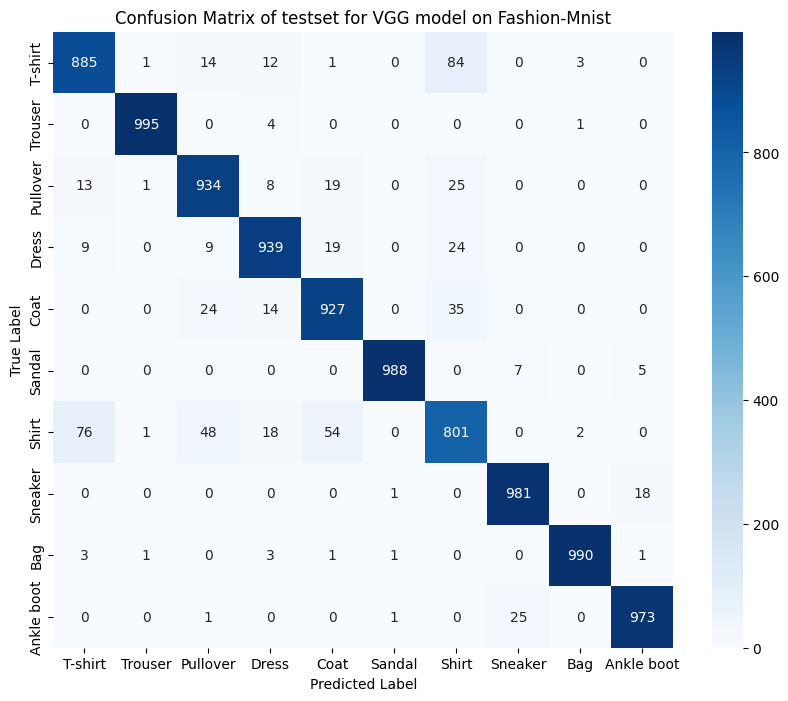

In [ ]:
# Load the CIFAR-10 dataset
fashion_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('fashion_mnist', 1)

# Initialize FASHIONVGG without training and specify the input shape
vgg_model = FASHIONVGG(input_shape=input_shape, train=False)

# Compile the model
vgg_model.model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Setting up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# Setting up ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Setting up ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model training with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau
history = vgg_model.model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                              callbacks=[early_stopping, checkpoint, reduce_lr])

# Evaluate the model on the test set
test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

# Make predictions on the test set
y_hat = vgg_model.model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, np.argmax(y_hat, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=fashion_labels, yticklabels=fashion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of testset for VGG model on Fashion-Mnist')
plt.show()


##CIFAR-10 VGG-19


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
class CIFAR10VGG:
    def __init__(self, input_shape, train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = input_shape

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        # else:
        #     self.model.load_weights('CIFAR10VGG.h5')

    def build_model(self):
        weight_decay = self.weight_decay

        model = Sequential()
        num_max_pool_layers = 3 if self.x_shape[0] == 28 else 5  # Less pooling for smaller input

        # Block 1
        model.add(Conv2D(64, (3, 3), padding='same', input_shape=self.x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 2
        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 3
        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 4
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1

        # Block 5
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        if num_max_pool_layers > 0:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            num_max_pool_layers -= 1
        model.add(Dropout(0.5))

        # Flatten and fully connected layers
        model.add(Flatten())
        model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        return model

    def train(self, model, X_train, y_train):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Learning rate scheduler
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,batch_size = 256,
                            callbacks=[early_stopping, checkpoint, reduce_lr])

        # return model, history
        return model, history


Experiment on Dataset: cifar10, Training Ratio: 0.2
Epoch 1/200
250/250 [==============================] - 24s 44ms/step - loss: 5.1796 - accuracy: 0.1468 - val_loss: 5.9172 - val_accuracy: 0.1515 - lr: 0.0010
Epoch 2/200
250/250 [==============================] - 11s 42ms/step - loss: 4.5060 - accuracy: 0.2074 - val_loss: 5.5177 - val_accuracy: 0.1175 - lr: 0.0010
Epoch 3/200
250/250 [==============================] - 10s 41ms/step - loss: 4.1302 - accuracy: 0.2646 - val_loss: 4.3343 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/200
250/250 [==============================] - 10s 40ms/step - loss: 3.7947 - accuracy: 0.3180 - val_loss: 3.7539 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 5/200
250/250 [==============================] - 10s 39ms/step - loss: 3.4325 - accuracy: 0.3694 - val_loss: 4.0604 - val_accuracy: 0.2455 - lr: 0.0010
Epoch 6/200
250/250 [==============================] - 10s 40ms/step - loss: 3.1496 - accuracy: 0.4200 - val_loss: 3.0733 - val_accuracy: 0.4135 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 15s 62ms/step - loss: 1.3974 - accuracy: 0.8165 - val_loss: 1.6606 - val_accuracy: 0.7205 - lr: 2.5000e-04
Epoch 30/200
250/250 [==============================] - 10s 39ms/step - loss: 1.2639 - accuracy: 0.8456 - val_loss: 1.7238 - val_accuracy: 0.6940 - lr: 2.5000e-04
Epoch 31/200
250/250 [==============================] - 10s 42ms/step - loss: 1.2255 - accuracy: 0.8444 - val_loss: 1.6445 - val_accuracy: 0.7135 - lr: 2.5000e-04
Epoch 32/200
250/250 [==============================] - 10s 40ms/step - loss: 1.2025 - accuracy: 0.8482 - val_loss: 1.6734 - val_accuracy: 0.7050 - lr: 2.5000e-04
Epoch 33/200
250/250 [==============================] - 10s 40ms/step - loss: 1.1441 - accuracy: 0.8685 - val_loss: 1.6594 - val_accuracy: 0.7210 - lr: 2.5000e-04
Epoch 34/200
250/250 [==============================] - 10s 39ms/step - loss: 1.1439 - accuracy: 0.8670 - val_loss: 1.6777 - val_accuracy: 0.7290 - lr: 2.5000e-04
Epoch 35/200
250/250 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 31s 50ms/step - loss: 1.4629 - accuracy: 0.8047 - val_loss: 1.5366 - val_accuracy: 0.7790 - lr: 5.0000e-04
Epoch 29/200
625/625 [==============================] - 26s 41ms/step - loss: 1.4600 - accuracy: 0.8058 - val_loss: 1.5396 - val_accuracy: 0.7728 - lr: 5.0000e-04
Epoch 30/200
625/625 [==============================] - 26s 41ms/step - loss: 1.4467 - accuracy: 0.8145 - val_loss: 1.5973 - val_accuracy: 0.7648 - lr: 5.0000e-04
Epoch 31/200
625/625 [==============================] - 26s 41ms/step - loss: 1.4487 - accuracy: 0.8122 - val_loss: 1.5977 - val_accuracy: 0.7668 - lr: 5.0000e-04
Epoch 32/200
625/625 [==============================] - 30s 48ms/step - loss: 1.4471 - accuracy: 0.8152 - val_loss: 1.5274 - val_accuracy: 0.7864 - lr: 5.0000e-04
Epoch 33/200
625/625 [==============================] - 27s 42ms/step - loss: 1.4296 - accuracy: 0.8184 - val_loss: 1.5247 - val_accuracy: 0.7816 - lr: 5.0000e-04
Epoch 34/200
625/625 [=============

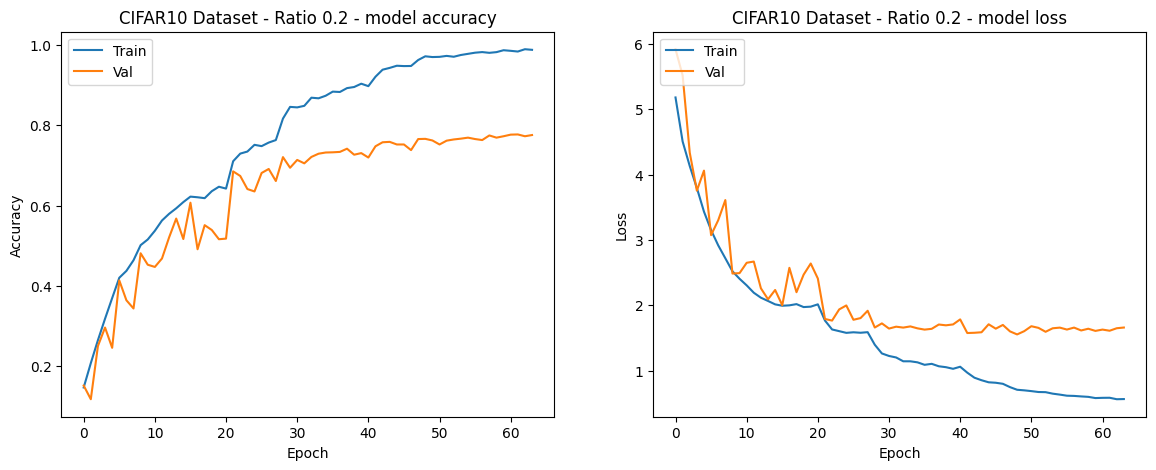

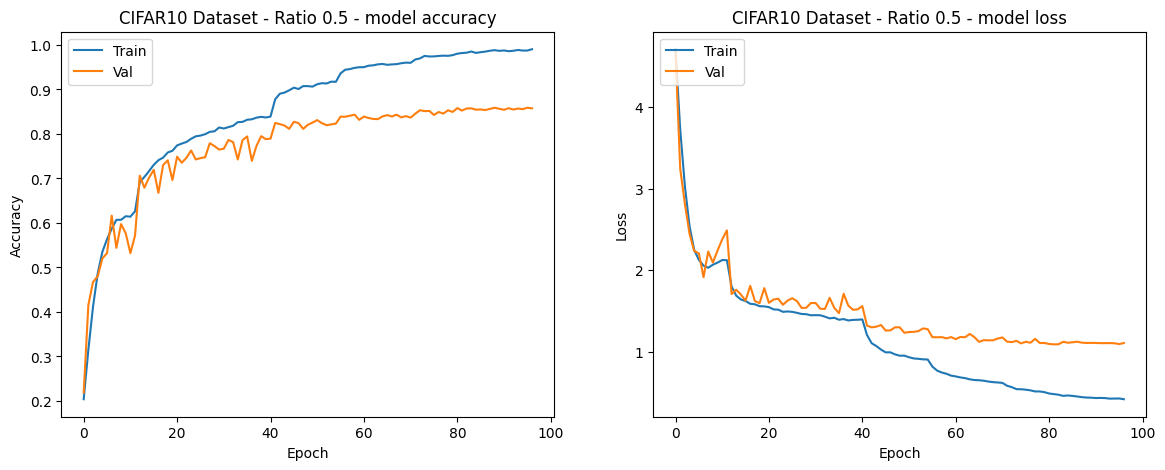

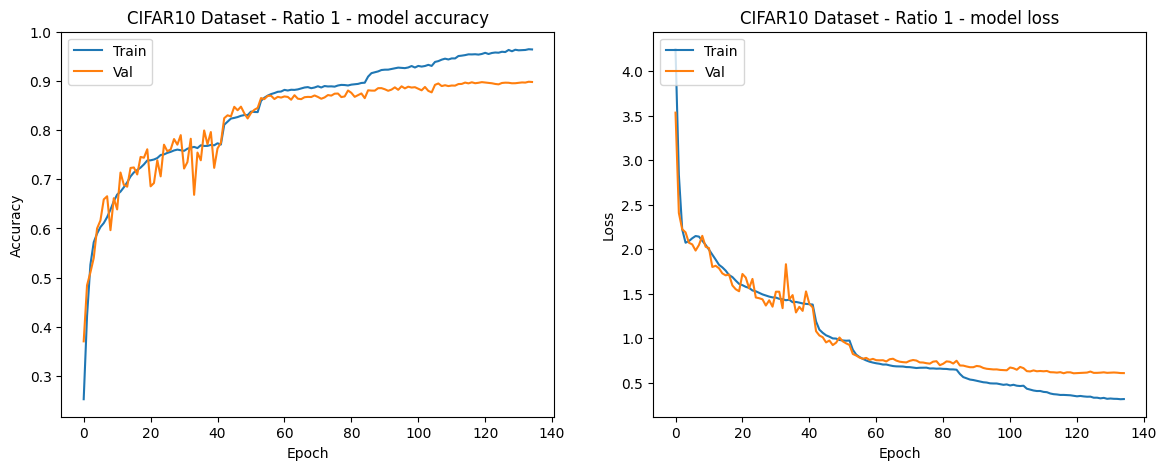

In [ ]:
all_histories = {}
# Main Loop - Iterate through datasets and ratios
for dataset in ['cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')

        # Load data and get the appropriate input shape
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Initialize CIFAR10VGG without training and specify the input shape
        vgg_model = CIFAR10VGG(input_shape=input_shape, train=False)


        # Train the model with the currently loaded data

        vgg_model.model, history = vgg_model.train(vgg_model.model, X_train, y_train)
        dataset_histories[ratio] = history.history

        # Load best weights from training
        vgg_model.model.load_weights('best_model.h5')

        # Evaluate the best model
        test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        print()

    all_histories[dataset] = dataset_histories
plot_metrics(all_histories)

Epoch 1/200
157/157 [==============================] - 44s 180ms/step - loss: 4.7334 - accuracy: 0.2109 - val_loss: 5.7454 - val_accuracy: 0.1026 - lr: 0.0010
Epoch 2/200
157/157 [==============================] - 27s 174ms/step - loss: 3.8733 - accuracy: 0.3535 - val_loss: 5.3654 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 3/200
157/157 [==============================] - 28s 175ms/step - loss: 3.3124 - accuracy: 0.4727 - val_loss: 3.9239 - val_accuracy: 0.2144 - lr: 0.0010
Epoch 4/200
157/157 [==============================] - 27s 175ms/step - loss: 2.8561 - accuracy: 0.5611 - val_loss: 2.8000 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 5/200
157/157 [==============================] - 23s 147ms/step - loss: 2.4453 - accuracy: 0.6254 - val_loss: 2.4555 - val_accuracy: 0.5916 - lr: 0.0010
Epoch 6/200
157/157 [==============================] - 23s 147ms/step - loss: 2.1221 - accuracy: 0.6724 - val_loss: 2.2495 - val_accuracy: 0.6099 - lr: 0.0010
Epoch 7/200
157/157 [=========================

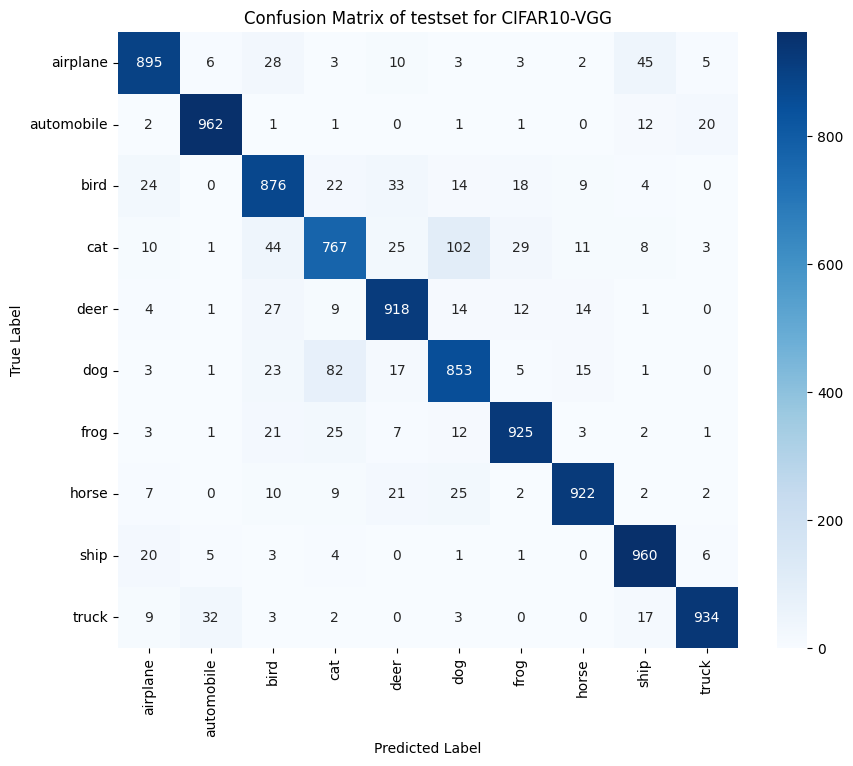

In [13]:
# Load the CIFAR-10 dataset
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', 1)

# Initialize the FASHIONVGG model
vgg_model = CIFAR10VGG(input_shape=input_shape, train=False)
vgg_model.model, history = vgg_model.train(vgg_model.model, X_train, y_train)

# Evaluate the model on the test set
test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

# Make predictions on the test set
y_hat = vgg_model.model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, np.argmax(y_hat, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels, yticklabels=cifar10_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of testset for CIFAR10-VGG')
plt.show()


###To compare the performance, we build again the VGG-8 to exam the performance on CIFAR-10

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class CIFAR10VGG8:
    def __init__(self, input_shape, train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = input_shape

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)

    def build_model(self):
        weight_decay = self.weight_decay

        model = Sequential()

        # Block 1
        model.add(Conv2D(64, (3, 3), padding='same', input_shape=self.x_shape, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Block 2
        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Block 3
        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Block 4
        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Block 5
        model.add(Flatten())
        model.add(Dense(512, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        return model

    def train(self, model, X_train, y_train):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,batch_size = 256,
                            callbacks=[early_stopping, checkpoint, reduce_lr])

        return model, history



Experiment on Dataset: cifar10, Training Ratio: 0.2
Epoch 1/200
248/250 [============================>.] - ETA: 0s - loss: 3.4932 - accuracy: 0.2831

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 31s 31ms/step - loss: 3.4929 - accuracy: 0.2833 - val_loss: 4.3366 - val_accuracy: 0.1290 - lr: 0.0010
Epoch 2/200
250/250 [==============================] - 6s 24ms/step - loss: 2.9881 - accuracy: 0.3939 - val_loss: 3.7128 - val_accuracy: 0.2165 - lr: 0.0010
Epoch 3/200
250/250 [==============================] - 6s 22ms/step - loss: 2.6730 - accuracy: 0.4613 - val_loss: 3.0298 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 4/200
250/250 [==============================] - 6s 24ms/step - loss: 2.4471 - accuracy: 0.5179 - val_loss: 2.5793 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 5/200
250/250 [==============================] - 6s 24ms/step - loss: 2.1988 - accuracy: 0.5830 - val_loss: 2.2661 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 6/200
250/250 [==============================] - 6s 23ms/step - loss: 2.0236 - accuracy: 0.6204 - val_loss: 2.2568 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 7/200
250/250 [==============================] - 6s 23ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 14s 23ms/step - loss: 1.3540 - accuracy: 0.8183 - val_loss: 1.3881 - val_accuracy: 0.7824 - lr: 5.0000e-04
Epoch 16/200
625/625 [==============================] - 14s 23ms/step - loss: 1.2265 - accuracy: 0.8348 - val_loss: 1.3342 - val_accuracy: 0.7920 - lr: 5.0000e-04
Epoch 17/200
625/625 [==============================] - 14s 22ms/step - loss: 1.2015 - accuracy: 0.8443 - val_loss: 1.3033 - val_accuracy: 0.8074 - lr: 5.0000e-04
Epoch 18/200
625/625 [==============================] - 14s 22ms/step - loss: 1.1895 - accuracy: 0.8461 - val_loss: 1.3483 - val_accuracy: 0.7990 - lr: 5.0000e-04
Epoch 19/200
625/625 [==============================] - 14s 23ms/step - loss: 1.1575 - accuracy: 0.8592 - val_loss: 1.2978 - val_accuracy: 0.8116 - lr: 5.0000e-04
Epoch 20/200
625/625 [==============================] - 14s 23ms/step - loss: 1.1419 - accuracy: 0.8630 - val_loss: 1.2723 - val_accuracy: 0.8168 - lr: 5.0000e-04
Epoch 21/200
625/625 [=============

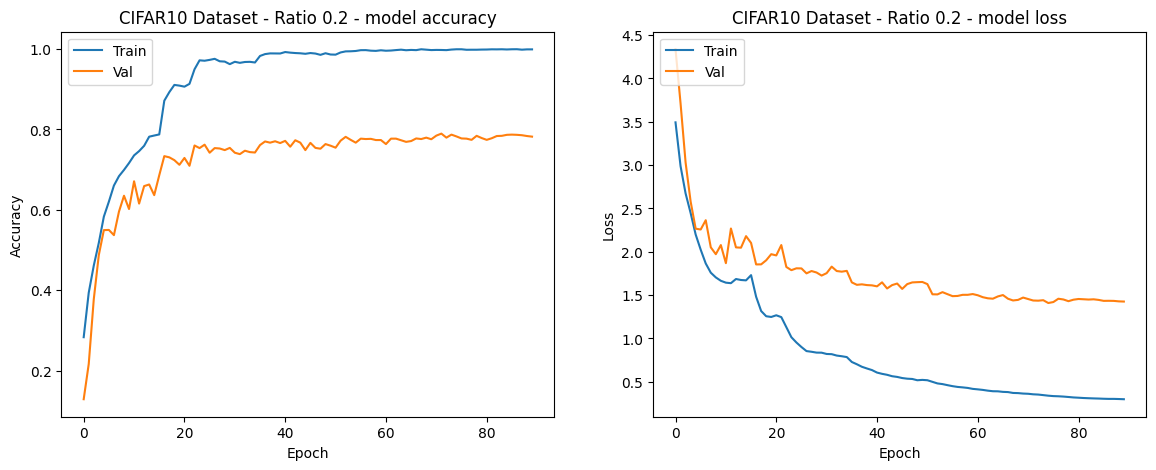

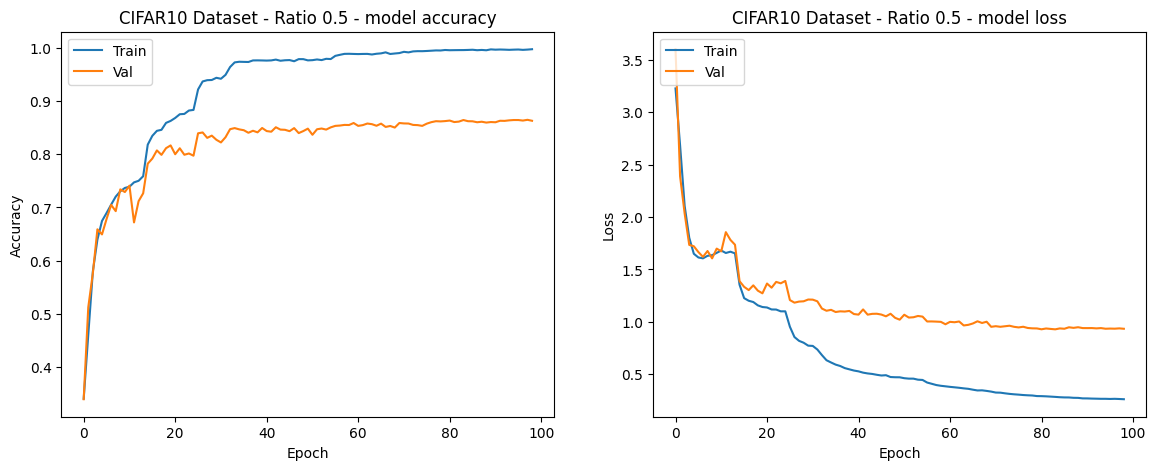

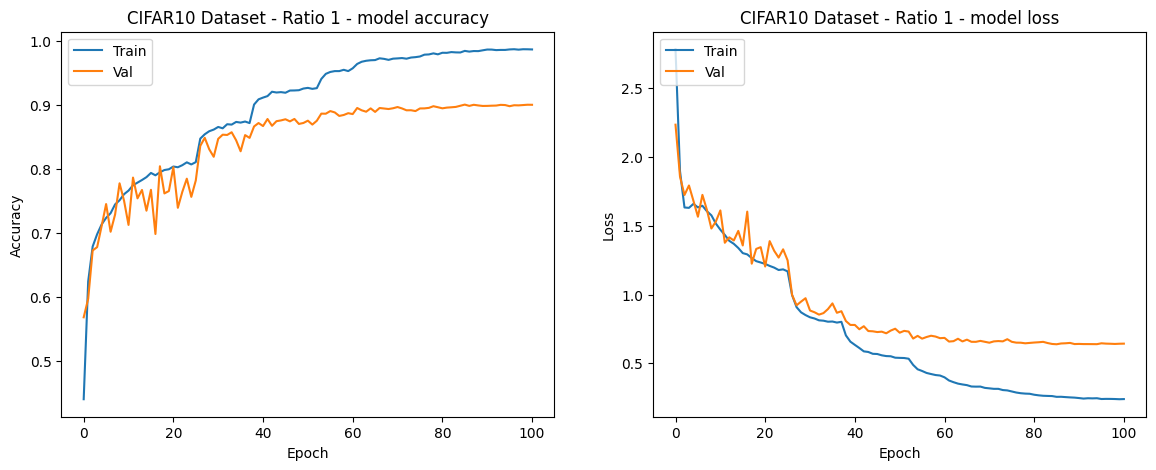

In [ ]:
all_histories = {}
# Main Loop - Iterate through datasets and ratios
for dataset in ['cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')

        # Load data and get the appropriate input shape
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Initialize CIFAR10VGG8 without training and specify the input shape
        vgg_model = CIFAR10VGG8(input_shape=input_shape, train=False)


        # Train the model with the currently loaded data

        vgg_model.model, history = vgg_model.train(vgg_model.model, X_train, y_train)
        dataset_histories[ratio] = history.history

        # Load best weights from training
        vgg_model.model.load_weights('best_model.h5')

        # Evaluate the best model
        test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        print()

    all_histories[dataset] = dataset_histories
plot_metrics(all_histories)

In [ ]:
vgg_model = CIFAR10VGG8(input_shape=[28,28,3], train=False)
print(vgg_model.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                       

###5-fold for CIFAR-10 VGG-8

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy = []
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', ratio = 1)
# Iterate over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Fold {fold+1}')

    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize CIFAR10VGG without training and specify the input shape
    vgg_model = CIFAR10VGG8(input_shape=input_shape, train=False)

    # Train the model with the currently loaded fold data
    vgg_model.model, history = vgg_model.train(vgg_model.model, X_train_fold, y_train_fold)

    # Load best weights from training
    # vgg_model.model.load_weights('best_model.h5')


    # Evaluate the model on the test set
    test_loss, test_acc = vgg_model.model.evaluate(X_test, y_test, verbose=2)
    accuracy.append(test_acc)
    print(f'Test accuracy for fold {fold+1}: {test_acc}')
    print()

print(f'Average test accuracy: {np.mean(accuracy)}')

Fold 1
Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 3.2260 - accuracy: 0.3605

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 30s 110ms/step - loss: 3.2260 - accuracy: 0.3605 - val_loss: 5.1945 - val_accuracy: 0.1221 - lr: 0.0010
Epoch 2/200
125/125 [==============================] - 12s 97ms/step - loss: 2.6230 - accuracy: 0.5025 - val_loss: 12.7000 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 3/200
125/125 [==============================] - 13s 102ms/step - loss: 2.2860 - accuracy: 0.5842 - val_loss: 5.0944 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 4/200
125/125 [==============================] - 13s 104ms/step - loss: 1.9993 - accuracy: 0.6465 - val_loss: 2.6743 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 5/200
125/125 [==============================] - 13s 105ms/step - loss: 1.7630 - accuracy: 0.7003 - val_loss: 2.1300 - val_accuracy: 0.5915 - lr: 0.0010
Epoch 6/200
125/125 [==============================] - 13s 104ms/step - loss: 1.5656 - accuracy: 0.7429 - val_loss: 1.9862 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 7/200
125/125 [==============================] - 13s

#CIFAR-10 ResNet

Experiment on Dataset: cifar10, Training Ratio: 0.2
Epoch 1/200
247/250 [============================>.] - ETA: 0s - loss: 3.1791 - accuracy: 0.2769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 18s 28ms/step - loss: 3.1739 - accuracy: 0.2781 - val_loss: 4.7246 - val_accuracy: 0.1095 - lr: 0.0010
Epoch 2/200
250/250 [==============================] - 4s 17ms/step - loss: 2.5550 - accuracy: 0.4089 - val_loss: 3.2720 - val_accuracy: 0.2165 - lr: 0.0010
Epoch 3/200
250/250 [==============================] - 5s 19ms/step - loss: 2.2205 - accuracy: 0.4715 - val_loss: 3.0209 - val_accuracy: 0.2325 - lr: 0.0010
Epoch 4/200
250/250 [==============================] - 4s 17ms/step - loss: 1.9727 - accuracy: 0.5119 - val_loss: 3.6625 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 5/200
250/250 [==============================] - 4s 17ms/step - loss: 1.8196 - accuracy: 0.5374 - val_loss: 2.3036 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 6/200
250/250 [==============================] - 5s 19ms/step - loss: 1.6870 - accuracy: 0.5569 - val_loss: 2.1036 - val_accuracy: 0.3855 - lr: 0.0010
Epoch 7/200
250/250 [==============================] - 6s 23ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 11s 18ms/step - loss: 1.0757 - accuracy: 0.7648 - val_loss: 1.2201 - val_accuracy: 0.7384 - lr: 0.0010
Epoch 20/200
625/625 [==============================] - 10s 17ms/step - loss: 1.0575 - accuracy: 0.7715 - val_loss: 1.9609 - val_accuracy: 0.4654 - lr: 0.0010
Epoch 21/200
625/625 [==============================] - 10s 16ms/step - loss: 1.0529 - accuracy: 0.7753 - val_loss: 1.3761 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 22/200
625/625 [==============================] - 11s 18ms/step - loss: 1.0331 - accuracy: 0.7801 - val_loss: 1.4555 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 23/200
625/625 [==============================] - 11s 17ms/step - loss: 1.0300 - accuracy: 0.7843 - val_loss: 1.3347 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 24/200
625/625 [==============================] - 11s 18ms/step - loss: 1.0295 - accuracy: 0.7830 - val_loss: 1.2780 - val_accuracy: 0.7166 - lr: 0.0010
Epoch 25/200
625/625 [==============================] - 11s

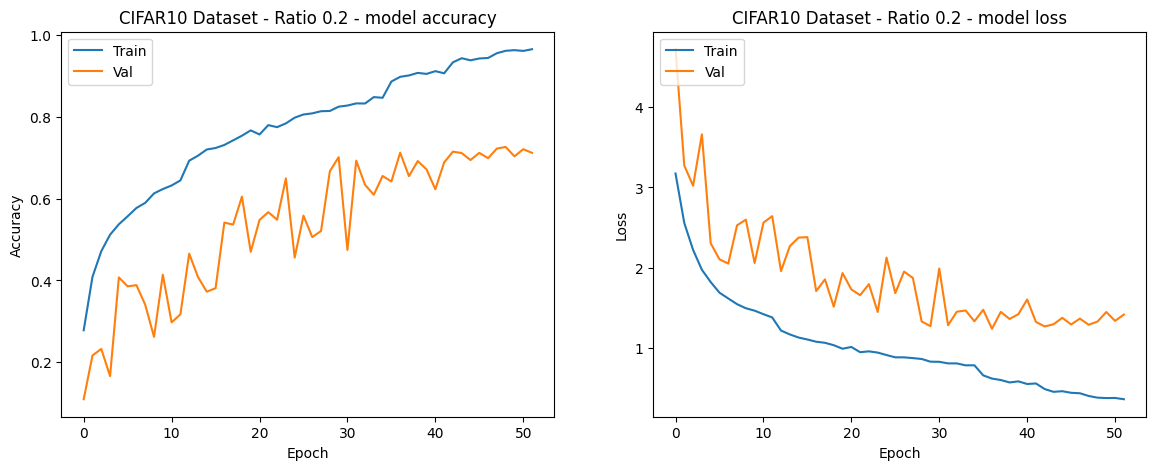

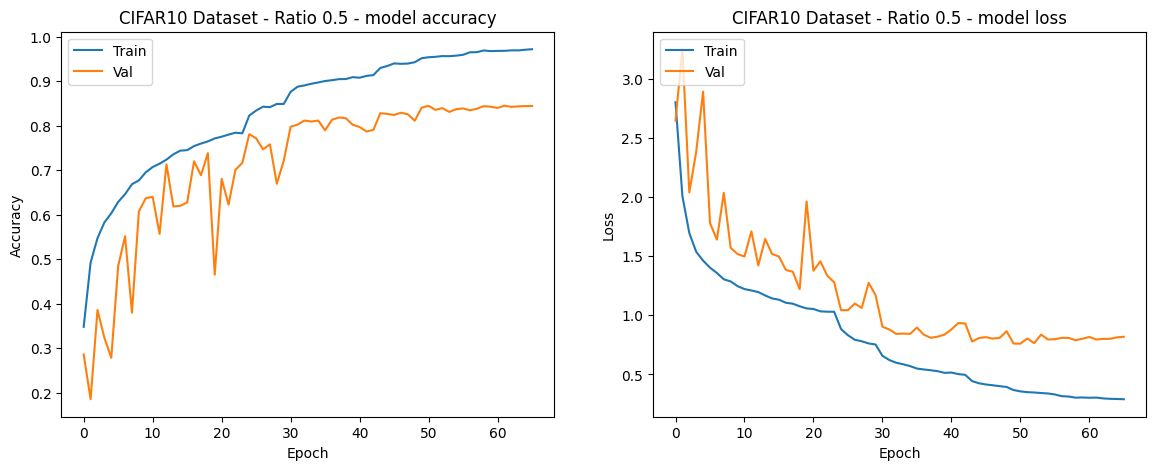

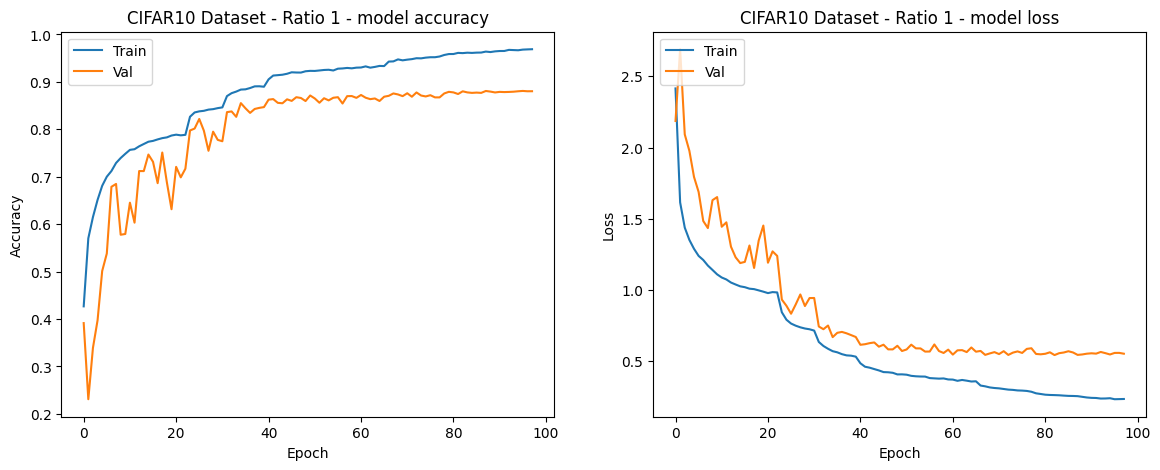

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

from keras.layers import Activation, Dropout
ratios = [0.2,0.5,1]
def load_data_equal_dist(dataset, ratio):
    # Load the data
    if dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train = np.expand_dims(X_train, axis=-1) / 255.0
        X_test = np.expand_dims(X_test, axis=-1) / 255.0
        input_shape = [28, 28, 1]
    elif dataset == 'cifar10':
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        X_train = X_train / 255.0
        X_test = X_test / 255.0
        input_shape = [32, 32, 3]

    # Stratified sampling to ensure equal distribution
    if ratio < 1:
        stratify_y = np.squeeze(y_train) if len(y_train.shape) > 1 else y_train
        X_train_resample, _, y_train_resample, _ = train_test_split(
            X_train, y_train, train_size=ratio, stratify=stratify_y)
    else:
        X_train_resample, y_train_resample = X_train, y_train

    return X_train_resample, y_train_resample, X_test, y_test, input_shape


# Define a simple residual block
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, kernel_size, padding='same', strides=stride, kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)

    # Shortcut path if block requires it
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, kernel_regularizer=regularizers.l2(0.0005))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding the shortcut to the network flow
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    return x
from keras.callbacks import ReduceLROnPlateau

class cifar10ResNet:
    def __init__(self, input_shape, train=True):
        self.num_classes = 10
        self.x_shape = input_shape

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)

    def build_model(self):
        input_shape = self.x_shape
        inputs = Input(shape=input_shape)

        x = Conv2D(64, (3, 3), strides=1, padding='same', kernel_regularizer=regularizers.l2(0.0005))(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
        x = Dropout(0.2)(x)  # add dropout

        x = residual_block(x, 64, conv_shortcut=True)
        x = residual_block(x, 64)
        x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
        x = Dropout(0.3)(x)  # add dropout

        x = residual_block(x, 128, conv_shortcut=True)
        x = residual_block(x, 128)
        x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
        x = Dropout(0.4)(x)  # add dropout

        x = residual_block(x, 256, conv_shortcut=True)
        x = residual_block(x, 256)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)  # add dropout

        x = Flatten()(x)
        x = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=x)
        return model

    def train(self, model, X_train, y_train):
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        history = model.fit(X_train, y_train, epochs=200, validation_split=0.2,
                            callbacks=[early_stopping, checkpoint, reduce_lr])

        return model, history




all_histories = {}
# Main Loop - Iterate through datasets and ratios
for dataset in ['cifar10']:
    dataset_histories = {}  # Dictionary to keep each dataset's training histories
    for ratio in ratios:
        print(f'Experiment on Dataset: {dataset}, Training Ratio: {ratio}')

        # Load data and get the appropriate input shape
        X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist(dataset, ratio)

        # Initialize cifar10ResNet without training and specify the input shape
        resnet_model = cifar10ResNet(input_shape=input_shape, train=False)


        # Train the model with the currently loaded data

        resnet_model.model, history = resnet_model.train(resnet_model.model, X_train, y_train)
        dataset_histories[ratio] = history.history

        # Load best weights from training
        resnet_model.model.load_weights('best_model.h5')

        # Evaluate the best model
        test_loss, test_acc = resnet_model.model.evaluate(X_test, y_test, verbose=2)
        print(f'Dataset: {dataset}, Training Ratio: {ratio}, Test Loss: {test_loss}, Test Accuracy: {test_acc}')
        print()

    all_histories[dataset] = dataset_histories
plot_metrics(all_histories)

Epoch 1/200
1247/1250 [============================>.] - ETA: 0s - loss: 2.4225 - accuracy: 0.4233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 48s 17ms/step - loss: 2.4214 - accuracy: 0.4234 - val_loss: 2.6516 - val_accuracy: 0.2967 - lr: 0.0010
Epoch 2/200
1250/1250 [==============================] - 22s 17ms/step - loss: 1.6391 - accuracy: 0.5624 - val_loss: 2.9910 - val_accuracy: 0.1913 - lr: 0.0010
Epoch 3/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4580 - accuracy: 0.6097 - val_loss: 2.1056 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 4/200
1250/1250 [==============================] - 22s 18ms/step - loss: 1.3649 - accuracy: 0.6454 - val_loss: 1.8048 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 5/200
1250/1250 [==============================] - 22s 17ms/step - loss: 1.2972 - accuracy: 0.6769 - val_loss: 1.6504 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 6/200
1250/1250 [==============================] - 21s 16ms/step - loss: 1.2422 - accuracy: 0.6946 - val_loss: 1.5923 - val_accuracy: 0.6218 - lr: 0.0010
Epoch 7/200
1250/1250 [=============================

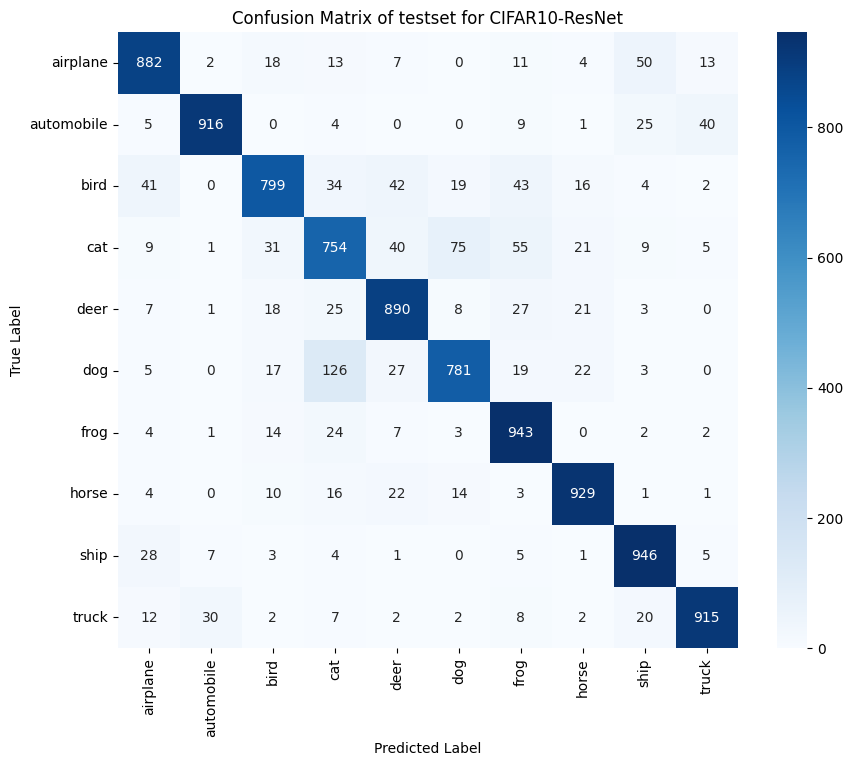

In [ ]:
# Load the CIFAR-10 dataset
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', 1)

# Initialize the FASHIONVGG model
res_model = cifar10ResNet(input_shape=input_shape, train=False)
res_model.model, history = res_model.train(res_model.model, X_train, y_train)

# Evaluate the model on the test set
test_loss, test_acc = res_model.model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_acc}')

# Make predictions on the test set
y_hat = res_model.model.predict(X_test)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, np.argmax(y_hat, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_labels, yticklabels=cifar10_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of testset for CIFAR10-ResNet')
plt.show()


##k-fold for resnet in cifar10

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
X_train, y_train, X_test, y_test, input_shape = load_data_equal_dist('cifar10', ratio = 1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accuracy = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Fold {fold+1}')

    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize CIFAR10VGG without training and specify the input shape
    resnet_model = cifar10ResNet(input_shape=input_shape, train=False)

    # Train the model with the currently loaded fold data
    resnet_model.model, history = resnet_model.train(resnet_model.model,  X_train_fold, y_train_fold)

    # Load best weights from training
    # resnet_model.model.load_weights('best_model.h5')

    # Evaluate the model on the test set
    test_loss, test_acc = resnet_model.model.evaluate(X_test, y_test, verbose=2)
    accuracy.append(test_acc)
    print(f'Test accuracy for fold {fold+1}: {test_acc}')
    print()

print(f'Average test accuracy: {np.mean(accuracy)}')


Fold 1
Epoch 1/200
1000/1000 [==============================] - 26s 17ms/step - loss: 2.5452 - accuracy: 0.3991 - val_loss: 5.1112 - val_accuracy: 0.1107 - lr: 0.0010
Epoch 2/200
1000/1000 [==============================] - 16s 16ms/step - loss: 1.7257 - accuracy: 0.5482 - val_loss: 3.4236 - val_accuracy: 0.2041 - lr: 0.0010
Epoch 3/200
1000/1000 [==============================] - 16s 16ms/step - loss: 1.4928 - accuracy: 0.6017 - val_loss: 2.1845 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 4/200
1000/1000 [==============================] - 16s 16ms/step - loss: 1.3944 - accuracy: 0.6325 - val_loss: 1.8816 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 5/200
1000/1000 [==============================] - 17s 17ms/step - loss: 1.3158 - accuracy: 0.6629 - val_loss: 2.0932 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 6/200
1000/1000 [==============================] - 16s 16ms/step - loss: 1.2744 - accuracy: 0.6821 - val_loss: 1.5847 - val_accuracy: 0.5790 - lr: 0.0010
Epoch 7/200
1000/1000 [==========